In [ ]:
# @title
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import matplotlib.pyplot as plt

# 1. 读取数据
data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx')

# 只重命名前5列
data.columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(0, 1024)]

# 使用LabelEncoder进行波形分类的数值化处理
le = LabelEncoder()
data['waveform'] = le.fit_transform(data['waveform'])  # 自动转换波形标签为数值

# 只选择数值类型的数据，避免非数值列导致问题
X_raw = data.iloc[:, 4:]  # 磁通密度数据
X_raw = X_raw.select_dtypes(include=[np.number])

y = data['waveform']  # 励磁波形类型

# 2. 特征提取函数
def extract_features(X):
    features = pd.DataFrame()

    # 1. 时域统计特征
    features['mean'] = np.mean(X, axis=1)
    features['std'] = np.std(X, axis=1)
    features['max'] = np.max(X, axis=1)
    features['min'] = np.min(X, axis=1)
    features['range'] = features['max'] - features['min']
    features['skew'] = X.apply(lambda row: skew(row), axis=1)
    features['kurtosis'] = X.apply(lambda row: kurtosis(row), axis=1)

    # 2. 波形特征
    # 每一行中的最大斜率（近似于梯度）
    def max_gradient(row):
        return np.max(np.gradient(row))

    # 每一行的最小斜率
    def min_gradient(row):
        return np.min(np.gradient(row))

    features['max_gradient'] = X.apply(lambda row: max_gradient(row), axis=1)
    features['min_gradient'] = X.apply(lambda row: min_gradient(row), axis=1)

    # 3. 频域特征（傅里叶变换）
    def compute_fft_features(row):
        fft_vals = np.abs(fft(row))  # 计算傅里叶变换的绝对值
        fft_power = fft_vals ** 2  # 计算频谱的功率
        return pd.Series({
            'fft_max_freq': fft_vals.argmax(),  # 最大频率
            'fft_max_val': fft_vals.max(),  # 最大频率幅值
            'fft_power_sum': np.sum(fft_power)  # 频谱能量
        })

    fft_features = X.apply(compute_fft_features, axis=1)
    features = pd.concat([features, fft_features], axis=1)

    return features

# 3. 提取特征
X = extract_features(X_raw)

# 4. 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 分类模型 - 随机森林
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. 模型评估
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# 输出测试集中励磁波形分类的数量
print(pd.Series(y_pred).value_counts())


KeyError: 'ALIGNED'

In [ ]:
# @title
# 检查是否有列名或数据包含 'ALIGNED'
aligned_cols = [col for col in X_raw.columns if 'ALIGNED' in col]
print("包含 'ALIGNED' 的列: ", aligned_cols)

包含 'ALIGNED' 的列:  []


In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft
import matplotlib.pyplot as plt

# 1. 读取数据
data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx')

# 只重命名前5列
data.columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(0, 1024)]

# 使用LabelEncoder进行波形分类的数值化处理
le = LabelEncoder()
data['waveform'] = le.fit_transform(data['waveform'])  # 自动转换波形标签为数值

# data.columns = data.columns.str.strip().str.lower()  # 将列名转为小写并去除空格
print(data.columns)  # 再次检查列名
print(data.head())
# print(data.info())
# print(data.describe())

In [66]:
data

T/oC    f/Hz         P_w/m3  waveform    B(t)_0    B(t)_1    B(t)_2  \
0        25   50030    1997.955250         1  0.000213  0.000389  0.000566   
1        25   50020    2427.749830         1 -0.000551 -0.000358 -0.000165   
2        25   50020    3332.725760         1 -0.003780 -0.003564 -0.003349   
3        25   50020    4502.908007         1 -0.000511 -0.000267 -0.000023   
4        25   50030    6063.023248         1  0.000458  0.000732  0.001007   
...     ...     ...            ...       ...       ...       ...       ...   
12395    90  199190   20604.900210         3 -0.017758 -0.017339 -0.016932   
12396    90  199190   26504.284280         3 -0.019690 -0.019227 -0.018776   
12397    90  199190   46232.491530         3 -0.024998 -0.024411 -0.023838   
12398    90  199190   61458.085900         3 -0.027988 -0.027329 -0.026687   
12399    90  199190  107581.189300         3 -0.035228 -0.034397 -0.033586   

         B(t)_3    B(t)_4    B(t)_5  ...  B(t)_1017  B(t)_1018  B(t)_1019  \
0      0.000743  0.000919  0.001096  ...  -0.001022  -0.000846  -0.000669   
1      0.000028  0.000221  0.000413  ...  -0.001899  -0.001707  -0.001515   
2     -0.003134 -0.002919 -0.002704  ...  -0.005285  -0.005070  -0.004855   
3      0.000222  0.000466  0.000711  ...  -0.002220  -0.001976  -0.001732   
4      0.001281  0.001555  0.001830  ...  -0.001466  -0.001192  -0.000917   
...         ...       ...       ...  ...        ...        ...        ...   
12395 -0.016534 -0.016140 -0.015745  ...  -0.019692  -0.019528  -0.019356   
12396 -0.018334 -0.017895 -0.017456  ...  -0.021886  -0.021706  -0.021513   
12397 -0.023278 -0.022722 -0.022165  ...  -0.027739  -0.027509  -0.027266   
12398 -0.026060 -0.025438 -0.024816  ...  -0.031056  -0.030793  -0.030516   
12399 -0.032793 -0.032006 -0.031219  ...  -0.039073  -0.038747  -0.038403   

       B(t)_1020  B(t)_1021  B(t)_1022  B(t)_1023    material        Bm  \
0      -0.000492  -0.000316  -0.000140   0.000036  material_1  0.028849   
1      -0.001322  -0.001129  -0.000937  -0.000744  material_1  0.031419   
2      -0.004640  -0.004425  -0.004210  -0.003995  material_1  0.035535   
3      -0.001488  -0.001244  -0.001000  -0.000756  material_1  0.040015   
4      -0.000642  -0.000367  -0.000092   0.000183  material_1  0.045028   
...          ...        ...        ...        ...         ...       ...   
12395  -0.019157  -0.018903  -0.018573  -0.018180  material_4  0.034867   
12396  -0.021285  -0.020987  -0.020605  -0.020159  material_4  0.038341   
12397  -0.026981  -0.026614  -0.026142  -0.025587  material_4  0.048877   
12398  -0.030196  -0.029787  -0.029264  -0.028647  material_4  0.054889   
12399  -0.038001  -0.037487  -0.036831  -0.036058  material_4  0.069135   

       transmission_energy  
0              1443.296709  
1              1571.587184  
2              1777.447095  
3              2001.571458  
4              2252.732329  
...                    ...  
12395          6945.182230  
12396          7637.188209  
12397          9735.819988  
12398         10933.350467  
12399         13771.097257  

[12400 rows x 1031 columns]

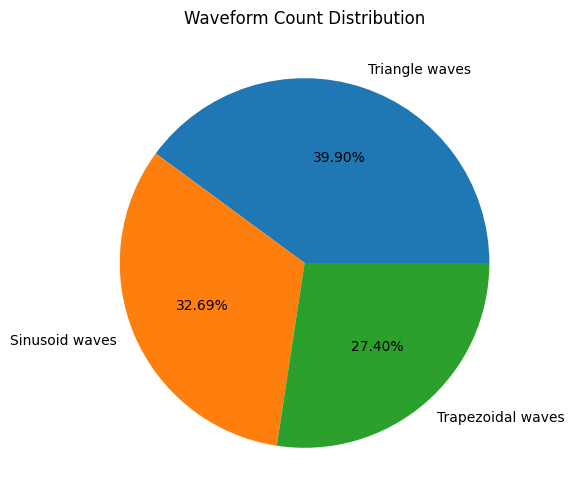

In [69]:
import matplotlib.pyplot as plt

waveform_labels = {2: 'Triangle waves', 3: 'Trapezoidal waves', 1: 'Sinusoid waves'}

# 重新计算波形的分布
waveform_count_distribution = data['waveform'].value_counts()

# 使用字典将数值映射为波形名称
waveform_count_distribution.index = waveform_count_distribution.index.map(waveform_labels)

# 绘制饼图
plt.figure(figsize=(8, 6))
waveform_count_distribution.plot.pie(autopct='%1.2f%%', labels=waveform_count_distribution.index)
plt.title('Waveform Count Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()


In [70]:
waveform_count_distribution

waveform
Triangle waves       4948
Sinusoid waves       4054
Trapezoidal waves    3398
Name: count, dtype: int64

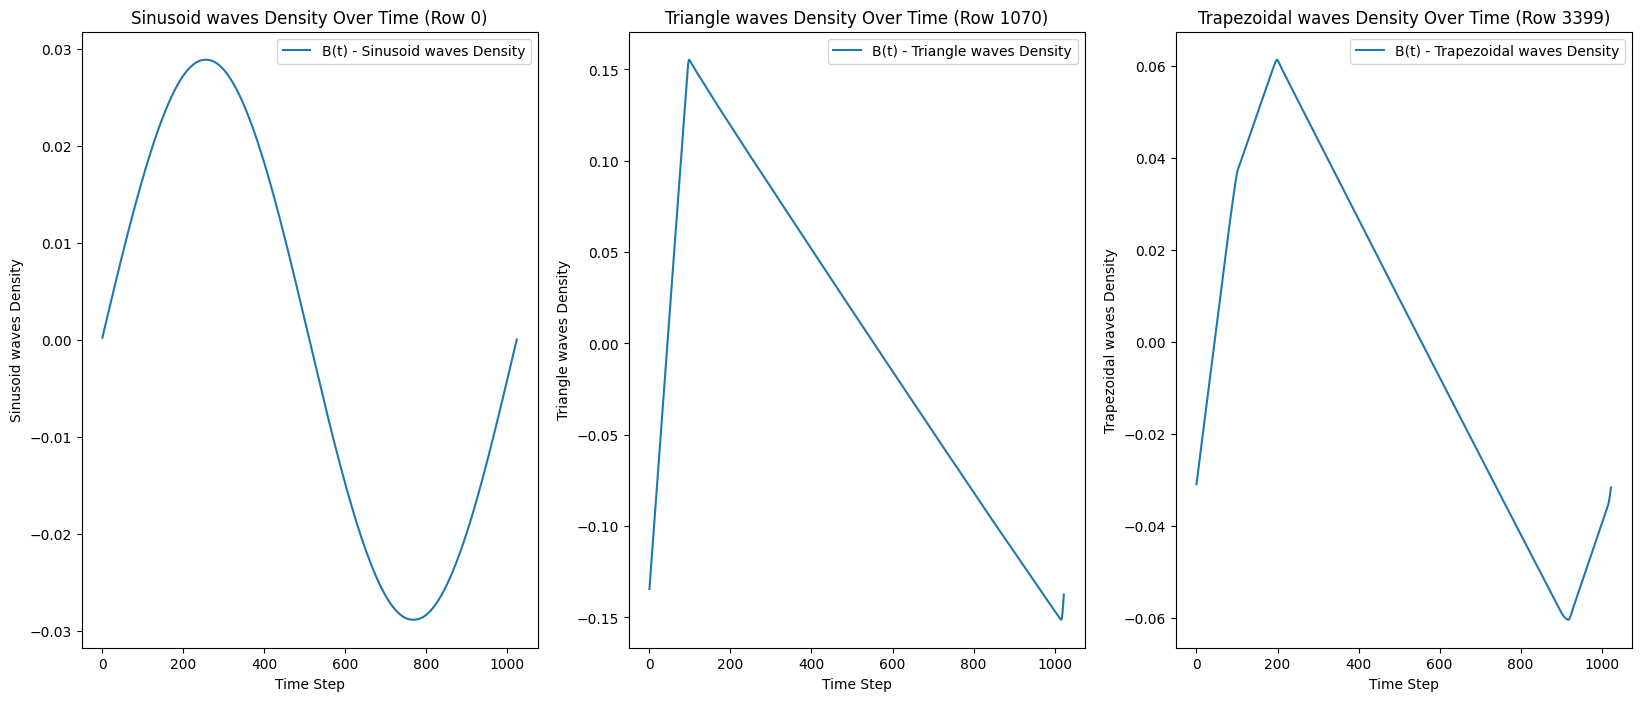

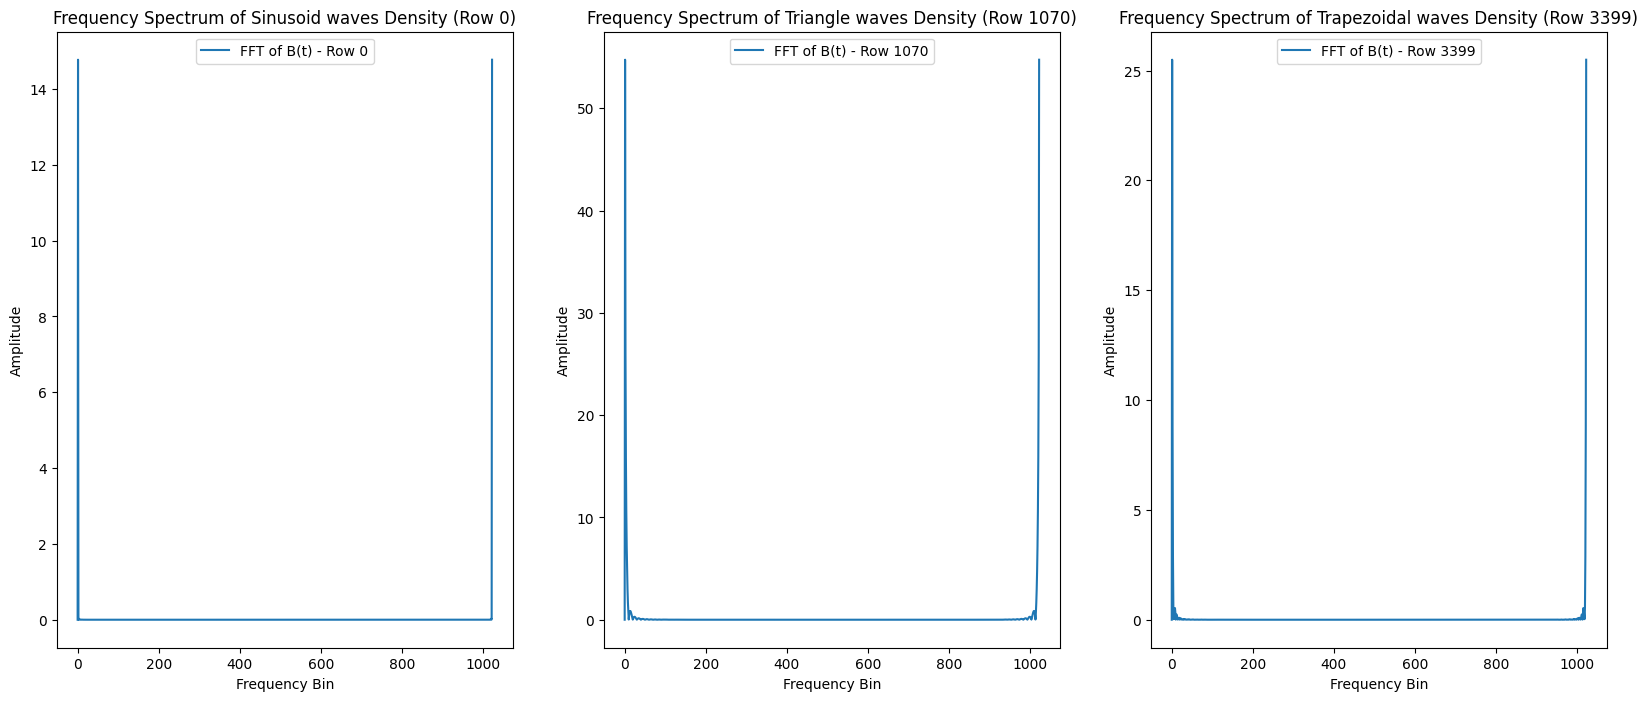

In [ ]:
# 可视化 - 选择其中一行的原始波动图（时域数据）
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.plot(X_raw[0, :], label='B(t) - Sinusoid waves Density')
plt.title('Sinusoid waves Density Over Time (Row 0)')
plt.xlabel('Time Step')
plt.ylabel('Sinusoid waves Density')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(X_raw[1070, :], label='B(t) - Triangle waves Density')
plt.title('Triangle waves Density Over Time (Row 1070)')
plt.xlabel('Time Step')
plt.ylabel('Triangle waves Density')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(X_raw[3399, :], label='B(t) - Trapezoidal waves Density')
plt.title('Trapezoidal waves Density Over Time (Row 3399)')
plt.xlabel('Time Step')
plt.ylabel('Trapezoidal waves Density')
plt.legend()

plt.show()

# 可视化 - 对应的频域图（傅里叶变换后的频谱）
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
fft_vals_row = np.abs(fft(X_raw[0, :]))
plt.plot(fft_vals_row, label='FFT of B(t) - Row 0')
plt.title('Frequency Spectrum of Sinusoid waves Density (Row 0)')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 3, 2)
fft_vals_row = np.abs(fft(X_raw[1070, :]))
plt.plot(fft_vals_row, label='FFT of B(t) - Row 1070')
plt.title('Frequency Spectrum of Triangle waves Density (Row 1070)')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 3, 3)
fft_vals_row = np.abs(fft(X_raw[3399, :]))
plt.plot(fft_vals_row, label='FFT of B(t) - Row 3399')
plt.title('Frequency Spectrum of Trapezoidal waves Density (Row 3399)')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

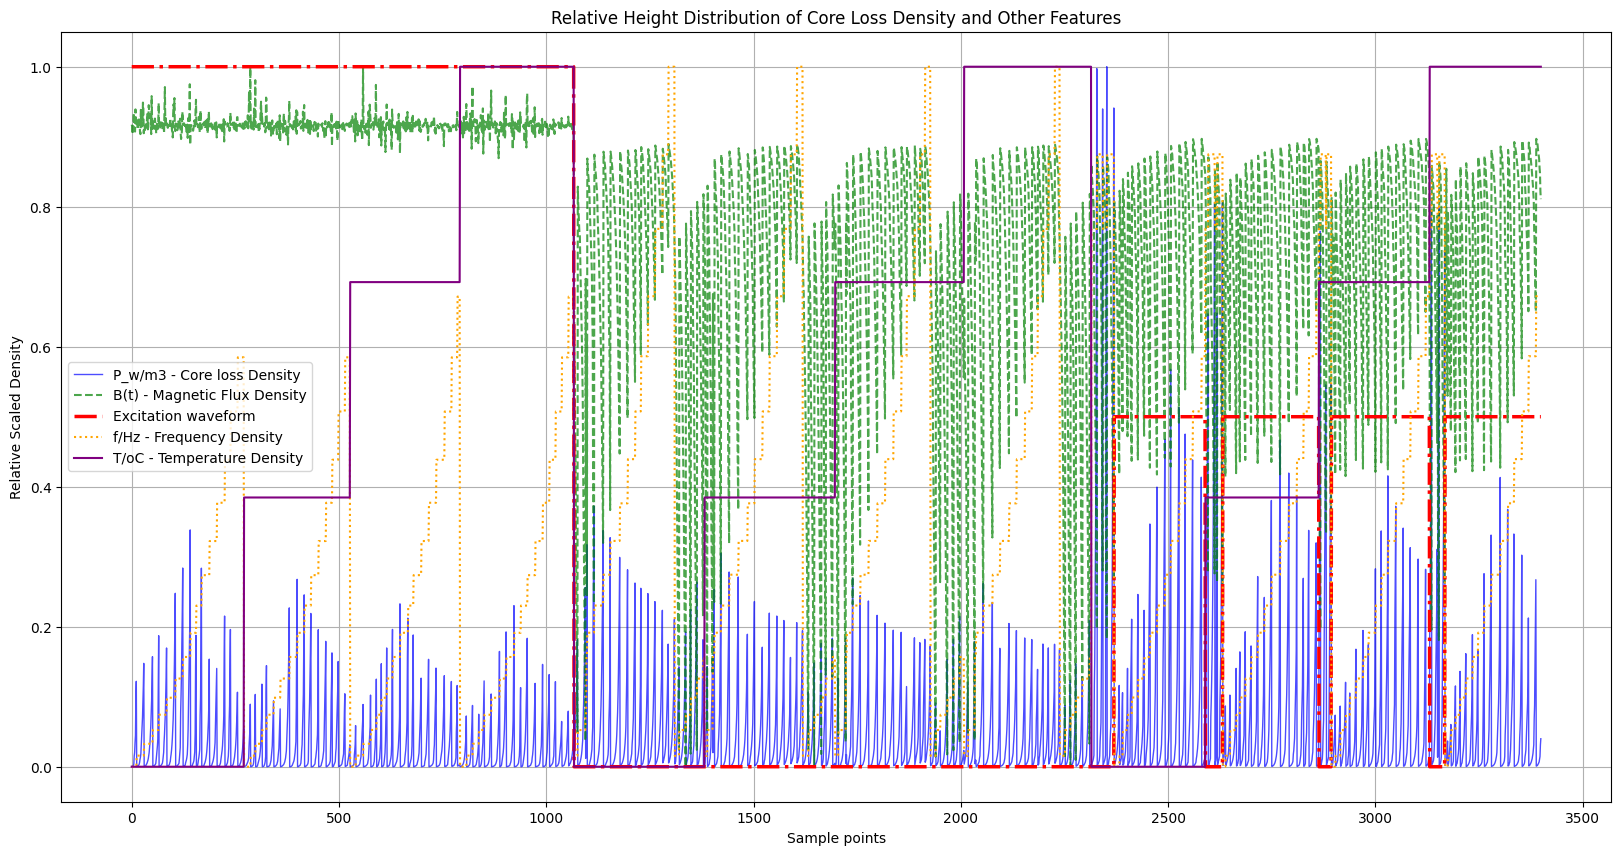

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data['B(t)_max'] = np.max(data.iloc[:, 4:], axis=1)
data['B(t)_min'] = np.min(data.iloc[:, 4:], axis=1)
data['B(t)_mm'] = data['B(t)_max'] - data['B(t)_min']
# 提取需要绘制的列
columns_to_plot = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform', 'B(t)_0']
data_to_plot = data[columns_to_plot]

# 对数据进行归一化
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_to_plot), columns=columns_to_plot)

# 绘制相对高度分布
plt.figure(figsize=(20, 10))
plt.plot(data_normalized['P_w/m3'], label='P_w/m3 - Core loss Density', color='blue', linewidth=1, alpha=0.7)

# 绘制其他特征相对高度分布
plt.plot(data_normalized['B(t)_0'], label='B(t) - Magnetic Flux Density', color='green', linestyle='--', alpha=0.7)
plt.plot(data_normalized['waveform'], label='Excitation waveform', color='red', linestyle='-.', linewidth=2.5)
plt.plot(data_normalized['f/Hz'], label='f/Hz - Frequency Density', color='orange', linestyle=':')
plt.plot(data_normalized['T/oC'], label='T/oC - Temperature Density', color='purple', linestyle='-', linewidth=1.5)

# 添加标题、标签和图例
plt.title('Relative Height Distribution of Core Loss Density and Other Features')
plt.xlabel('Sample points')
plt.ylabel('Relative Scaled Density')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
data[,4:]

SyntaxError: invalid syntax (<ipython-input-8-fb083712cbc9>, line 1)

In [ ]:
# 选择需要计算相关性的特征
columns_to_correlate = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform', 'B(t)_0']
data_corr = data[columns_to_correlate]

# 计算与 'P_w/m3' 的相关系数
correlation_with_loss = data_corr.corr()['P_w/m3']

# 打印相关系数
print("Correlation with Core Loss Density (P_w/m3):")
print(correlation_with_loss)


Correlation with Core Loss Density (P_w/m3):
T/oC       -0.084091
f/Hz        0.196744
P_w/m3      1.000000
waveform   -0.156383
B(t)_0     -0.558305
Name: P_w/m3, dtype: float64


In [ ]:
# @title
# 1. 提取时域和频域特征
def extract_features(X):
    features = pd.DataFrame()

    # 1. 时域统计特征
    # features['mean'] = np.mean(X, axis=1)
    features['std'] = np.std(X, axis=1)
    # features['max'] = np.max(X, axis=1)
    features['min'] = np.min(X, axis=1)

    return features

def get_labels(row):
    """
    转换为标签数据
    """
    one_hot_labels = pd.get_dummies(row)
    return one_hot_labels

# 2. 提取特征
X_raw = data.iloc[:, 4:].values  # 将数据框直接转为 numpy 数组
X = extract_features(X_raw)
y = get_labels(data['waveform'])

# 将特征组合成一个二维 NumPy 数组
# X = np.column_stack((std, min))

# 创建随机森林分类器
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#训练模型
rf.fit(X_train, y_train)

# 评估模型
accuracy = rf.score(X_test, y_test)
print(f"模型准确率: {accuracy:.2f}")

模型准确率: 0.97


In [75]:
data

T/oC    f/Hz         P_w/m3  waveform    B(t)_0    B(t)_1    B(t)_2  \
0        25   50030    1997.955250         1  0.000213  0.000389  0.000566   
1        25   50020    2427.749830         1 -0.000551 -0.000358 -0.000165   
2        25   50020    3332.725760         1 -0.003780 -0.003564 -0.003349   
3        25   50020    4502.908007         1 -0.000511 -0.000267 -0.000023   
4        25   50030    6063.023248         1  0.000458  0.000732  0.001007   
...     ...     ...            ...       ...       ...       ...       ...   
12395    90  199190   20604.900210         3 -0.017758 -0.017339 -0.016932   
12396    90  199190   26504.284280         3 -0.019690 -0.019227 -0.018776   
12397    90  199190   46232.491530         3 -0.024998 -0.024411 -0.023838   
12398    90  199190   61458.085900         3 -0.027988 -0.027329 -0.026687   
12399    90  199190  107581.189300         3 -0.035228 -0.034397 -0.033586   

         B(t)_3    B(t)_4    B(t)_5  ...  B(t)_1017  B(t)_1018  B(t)_1019  \
0      0.000743  0.000919  0.001096  ...  -0.001022  -0.000846  -0.000669   
1      0.000028  0.000221  0.000413  ...  -0.001899  -0.001707  -0.001515   
2     -0.003134 -0.002919 -0.002704  ...  -0.005285  -0.005070  -0.004855   
3      0.000222  0.000466  0.000711  ...  -0.002220  -0.001976  -0.001732   
4      0.001281  0.001555  0.001830  ...  -0.001466  -0.001192  -0.000917   
...         ...       ...       ...  ...        ...        ...        ...   
12395 -0.016534 -0.016140 -0.015745  ...  -0.019692  -0.019528  -0.019356   
12396 -0.018334 -0.017895 -0.017456  ...  -0.021886  -0.021706  -0.021513   
12397 -0.023278 -0.022722 -0.022165  ...  -0.027739  -0.027509  -0.027266   
12398 -0.026060 -0.025438 -0.024816  ...  -0.031056  -0.030793  -0.030516   
12399 -0.032793 -0.032006 -0.031219  ...  -0.039073  -0.038747  -0.038403   

       B(t)_1020  B(t)_1021  B(t)_1022  B(t)_1023    material        Bm  \
0      -0.000492  -0.000316  -0.000140   0.000036  material_1  0.028849   
1      -0.001322  -0.001129  -0.000937  -0.000744  material_1  0.031419   
2      -0.004640  -0.004425  -0.004210  -0.003995  material_1  0.035535   
3      -0.001488  -0.001244  -0.001000  -0.000756  material_1  0.040015   
4      -0.000642  -0.000367  -0.000092   0.000183  material_1  0.045028   
...          ...        ...        ...        ...         ...       ...   
12395  -0.019157  -0.018903  -0.018573  -0.018180  material_4  0.034867   
12396  -0.021285  -0.020987  -0.020605  -0.020159  material_4  0.038341   
12397  -0.026981  -0.026614  -0.026142  -0.025587  material_4  0.048877   
12398  -0.030196  -0.029787  -0.029264  -0.028647  material_4  0.054889   
12399  -0.038001  -0.037487  -0.036831  -0.036058  material_4  0.069135   

       transmission_energy  
0              1443.296709  
1              1571.587184  
2              1777.447095  
3              2001.571458  
4              2252.732329  
...                    ...  
12395          6945.182230  
12396          7637.188209  
12397          9735.819988  
12398         10933.350467  
12399         13771.097257  

[12400 rows x 1031 columns]

In [80]:
# @title

# 1. 提取时域和频域特征
def extract_features(X):
    features = pd.DataFrame()

    # 1. 时域统计特征
    features['mean'] = np.mean(X, axis=1)
    features['std'] = np.std(X, axis=1)
    features['max'] = np.max(X, axis=1)
    features['min'] = np.min(X, axis=1)
    features['range'] = features['max'] - features['min']
    features['skew'] = skew(X, axis=1)
    features['kurtosis'] = kurtosis(X, axis=1)

    # 2. 斜率特征（梯度）
    def compute_gradient(row):
        gradient = np.gradient(row)
        return np.max(gradient), np.min(gradient)

    gradients = np.apply_along_axis(compute_gradient, 1, X)
    features['max_gradient'] = gradients[:, 0]
    features['min_gradient'] = gradients[:, 1]

    # 3. 频域特征（傅里叶变换）
    fft_vals = np.abs(fft(X, axis=1))

    # 频谱能量
    psd = fft_vals ** 2  # Power Spectrum Density
    features['fft_power_sum'] = np.sum(psd, axis=1)

    # 频谱熵：衡量频谱的混乱度
    psd_norm = psd / np.sum(psd, axis=1, keepdims=True)
    features['fft_entropy'] = -np.sum(psd_norm * np.log(psd_norm + 1e-8), axis=1)

    # 频谱峰度（Kurtosis of Power Spectrum）
    features['fft_kurtosis'] = kurtosis(fft_vals, axis=1)

    # 最大频率对应的幅值
    features['fft_max_val'] = np.max(fft_vals, axis=1)

    # 最大频率的位置
    features['fft_max_freq'] = np.argmax(fft_vals, axis=1)

    return features

# 2. 提取特征
# 只选择数值类型的数据，避免非数值列导致问题
X_raw = data.iloc[:, 4:1028].values  # 将数据框直接转为 numpy 数组
X = extract_features(X_raw)
y = data['waveform']

# 3. 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 分类模型 - 随机森林
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# 5. 模型评估
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# 输出测试集中励磁波形分类的数量
print(pd.Series(y_pred).value_counts())

# # 获取预测的类别
# y_pred_classes = np.argmax(y_pred, axis=1)
# # 输出测试集中励磁波形分类的数量
# print(pd.Series(y_pred_classes).value_counts())


test_data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/test1.xlsx')
test_data.columns = ['serial number', 'T/oC', 'f/Hz', 'Core material'] + [f'B(t)_{i}' for i in range(0, 1024)]

X_test_raw = test_data.iloc[:, 4:].values
X_test = extract_features(X_test_raw)
y_test_pred = clf.predict(X_test)

test_data['waveform_prediction'] = y_test_pred

# 输出测试集的预测结果
print("Predictions for Test Data:")
print(test_data[['serial number', 'waveform_prediction']].head())

# 保存结果到文件
test_data[['serial number', 'waveform_prediction']].to_csv('test_predictions_1.csv', index=False)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       797
           2       1.00      1.00      1.00       977
           3       1.00      1.00      1.00       706

    accuracy                           1.00      2480
   macro avg       1.00      1.00      1.00      2480
weighted avg       1.00      1.00      1.00      2480

2    977
1    797
3    706
Name: count, dtype: int64
Predictions for Test Data:
   serial number  waveform_prediction
0              1                    2
1              2                    2
2              3                    2
3              4                    2
4              5                    2


Cross-Validation Accuracy Scores:  [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.000
Std CV Accuracy: 0.000


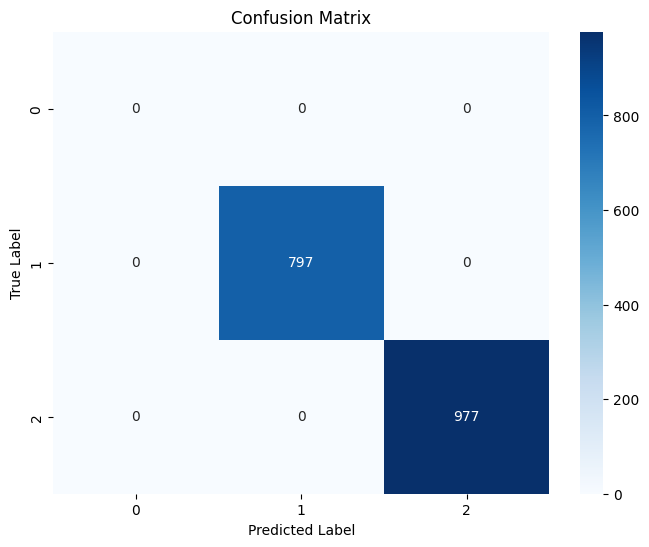

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Original number of features:  14
Reduced number of features:  4
Selected features:  ['skew', 'kurtosis', 'fft_entropy', 'fft_kurtosis']


ValueError: Found input variables with inconsistent numbers of samples: [2480, 80]

In [81]:
# @title
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

# 1. 交叉验证评估模型性能
def evaluate_with_cross_validation(X, y):
    # 如果 y 是多标签指示器，转换为单一类别标签
    if y.ndim > 1:
        y = np.argmax(y, axis=1)  # 获取每个样本的类别

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    # 使用 Stratified KFold 保证每个折叠中各类别比例一致
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 交叉验证得分（accuracy）
    cv_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
    print("Cross-Validation Accuracy Scores: ", cv_scores)
    print("Mean CV Accuracy: {:.3f}".format(cv_scores.mean()))
    print("Std CV Accuracy: {:.3f}".format(cv_scores.std()))

# 2. 混淆矩阵绘制
def plot_confusion_matrix(y_true, y_pred, labels):
    # 如果 y 是多标签指示器，转换为单一类别标签
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)  # 获取每个样本的类别

    # 如果 y 是多标签指示器，转换为单一类别标签
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)  # 获取每个样本的类别

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 3. 特征选择（基于特征重要性）
def select_important_features(X_train, y_train, X_test):
    # 训练随机森林分类器
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # 使用特征重要性来进行特征选择
    selector = SelectFromModel(clf, threshold='mean', prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    print("Original number of features: ", X_train.shape[1])
    print("Reduced number of features: ", X_train_selected.shape[1])

    selected_features = X_train.columns[selector.get_support()].tolist()
    print("Selected features: ", selected_features)

    return X_train_selected, X_test_selected, selector

# 交叉验证评估
evaluate_with_cross_validation(X, y)

# 绘制混淆矩阵
plot_confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# 特征选择
X_train_selected, X_test_selected, selector = select_important_features(X_train, y_train, X_test)

# 在特征选择后的数据上训练模型
clf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
clf_selected.fit(X_train_selected, y_train)
y_pred_selected = clf_selected.predict(X_test_selected)

# 输出特征选择后的模型性能
print(classification_report(y_test, y_pred_selected))
plot_confusion_matrix(y_test, y_pred_selected, labels=[0, 1, 2])


In [86]:
y_pred_selected.shape

(80,)

In [82]:
X_train.columns

Index(['mean', 'std', 'max', 'min', 'range', 'skew', 'kurtosis',
       'max_gradient', 'min_gradient', 'fft_power_sum', 'fft_entropy',
       'fft_kurtosis', 'fft_max_val', 'fft_max_freq'],
      dtype='object')

In [ ]:
y_single_label = np.argmax(y, axis=1)  # 转换为单一类别标签
y_single_label

array([2, 2, 2, ..., 1, 1, 1])

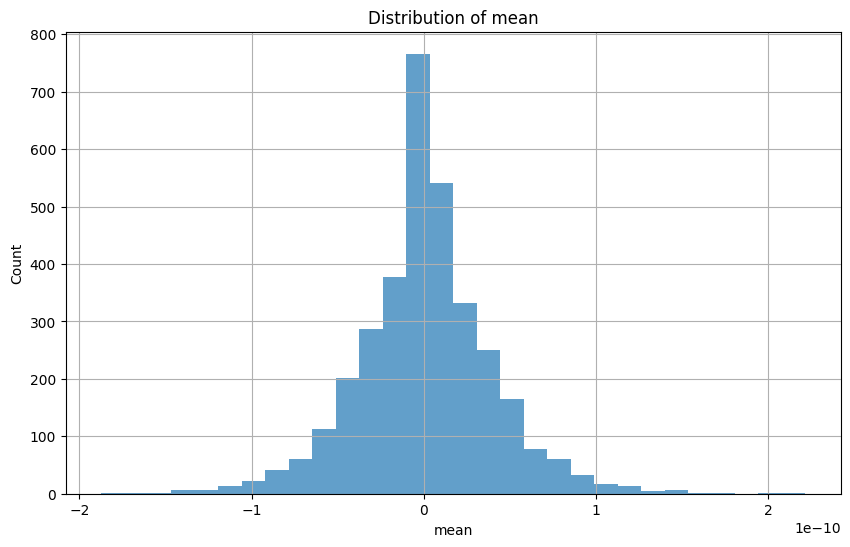

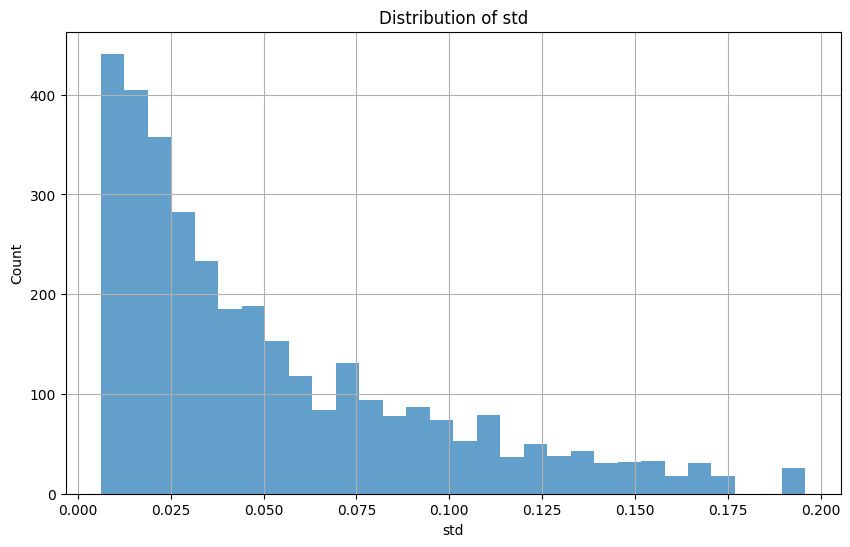

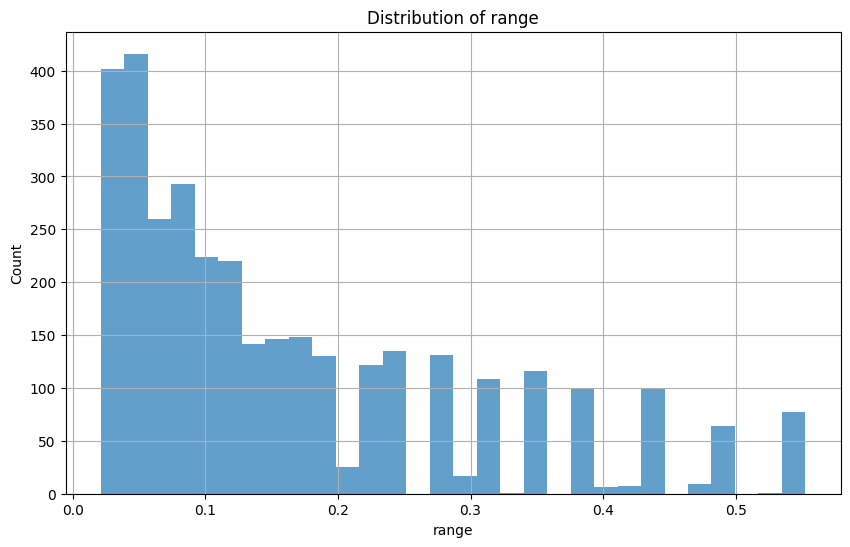

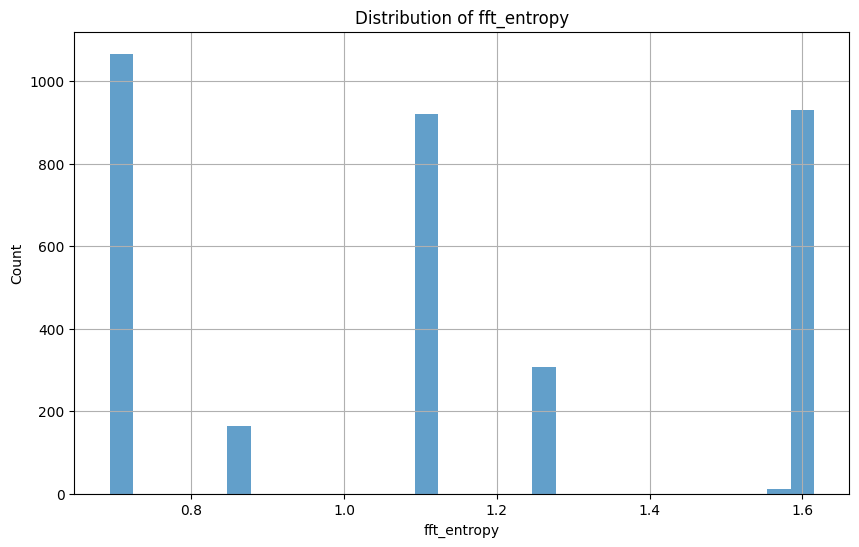

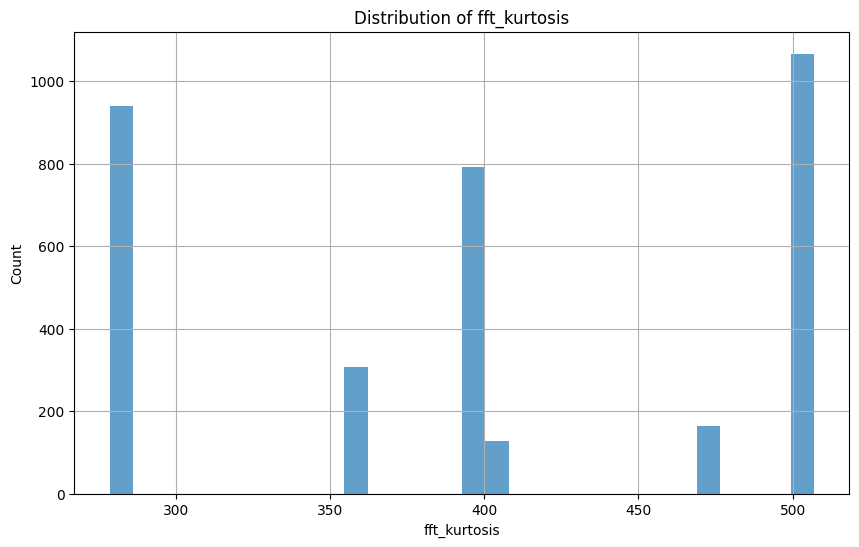

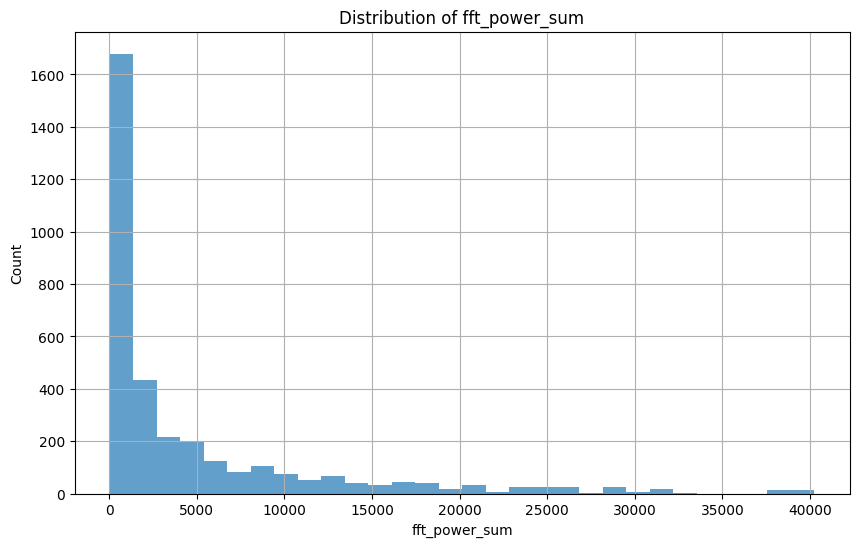

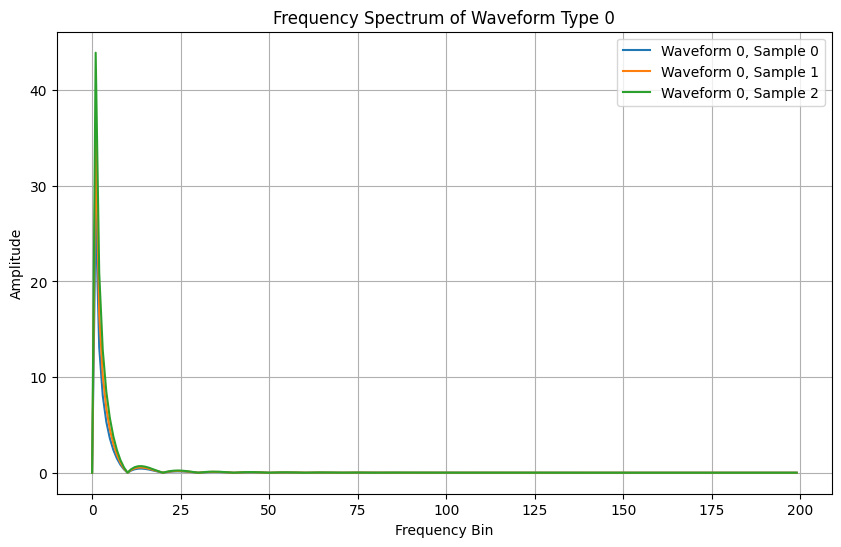

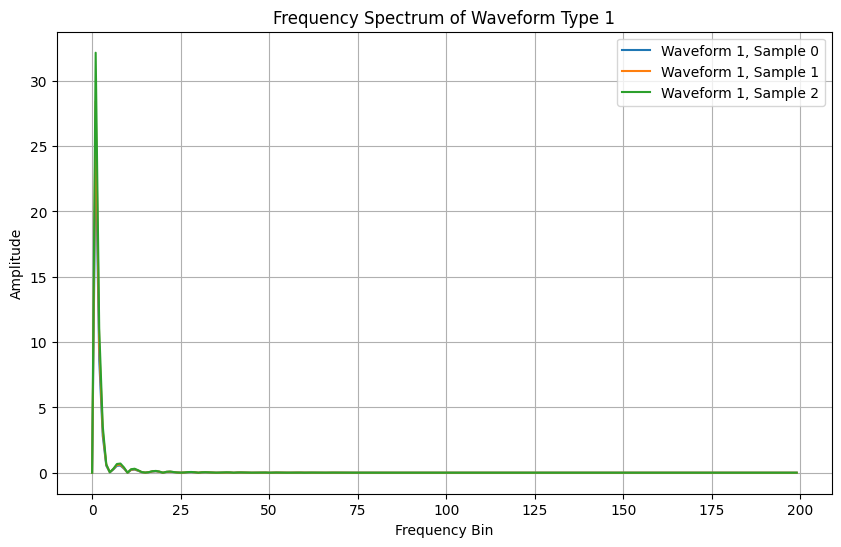

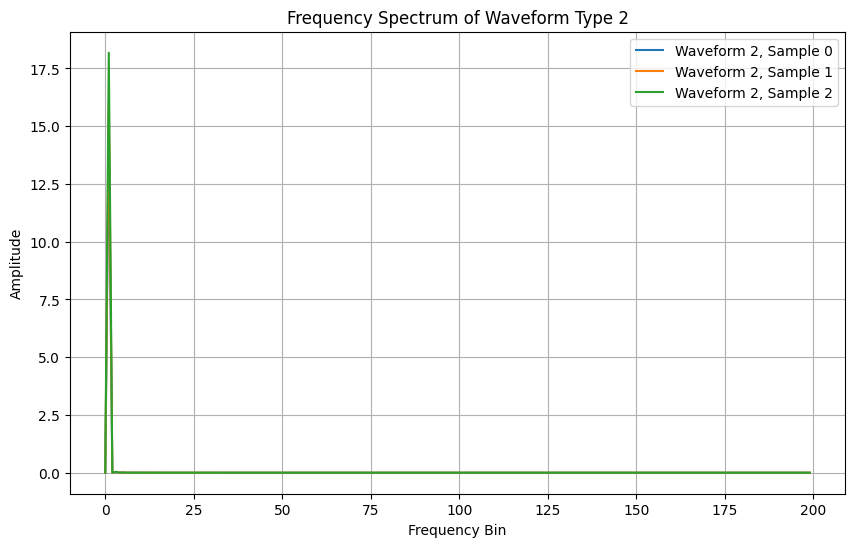

In [ ]:
# @title
# 可视化统计特征分布
def plot_feature_distribution(features, feature_name):
    plt.figure(figsize=(10, 6))
    plt.hist(features[feature_name], bins=30, alpha=0.7, label=feature_name)
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

# 绘制时域统计特征分布
plot_feature_distribution(X, 'mean')
plot_feature_distribution(X, 'std')
plot_feature_distribution(X, 'range')

# 绘制频域统计特征分布
plot_feature_distribution(X, 'fft_entropy')
plot_feature_distribution(X, 'fft_kurtosis')
plot_feature_distribution(X, 'fft_power_sum')

# 7. 不同波形类型的频谱比较
def plot_waveform_spectrum(X, y, waveform_label):
    idx = np.where(y == waveform_label)[0]
    X_waveform = X_raw[idx, :]

    plt.figure(figsize=(10, 6))
    for i in range(3):  # 选择3个样本进行比较
        fft_vals = np.abs(fft(X_waveform[i, :]))
        plt.plot(fft_vals[:200], label=f'Waveform {waveform_label}, Sample {i}')

    plt.title(f'Frequency Spectrum of Waveform Type {waveform_label}')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# 绘制不同波形类型的频谱图
plot_waveform_spectrum(X_raw, y, 0)  # 正弦波
plot_waveform_spectrum(X_raw, y, 1)  # 三角波
plot_waveform_spectrum(X_raw, y, 2)  # 梯形波


In [ ]:
print(data.isnull().sum())

t/oc         0
f/hz         0
p_w/m3       0
waveform     0
b(t)_0       0
            ..
b(t)_1019    0
b(t)_1020    0
b(t)_1021    0
b(t)_1022    0
b(t)_1023    0
Length: 1028, dtype: int64


In [ ]:
data.columns = data.columns.str.strip().str.lower()  # 将列名转为小写并去除空格
print(data.columns)  # 再次检查列名

Index(['t/oc', 'f/hz', 'p_w/m3', 'waveform', 'b(t)_0', 'b(t)_1', 'b(t)_2',
       'b(t)_3', 'b(t)_4', 'b(t)_5',
       ...
       'b(t)_1014', 'b(t)_1015', 'b(t)_1016', 'b(t)_1017', 'b(t)_1018',
       'b(t)_1019', 'b(t)_1020', 'b(t)_1021', 'b(t)_1022', 'b(t)_1023'],
      dtype='object', length=1028)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


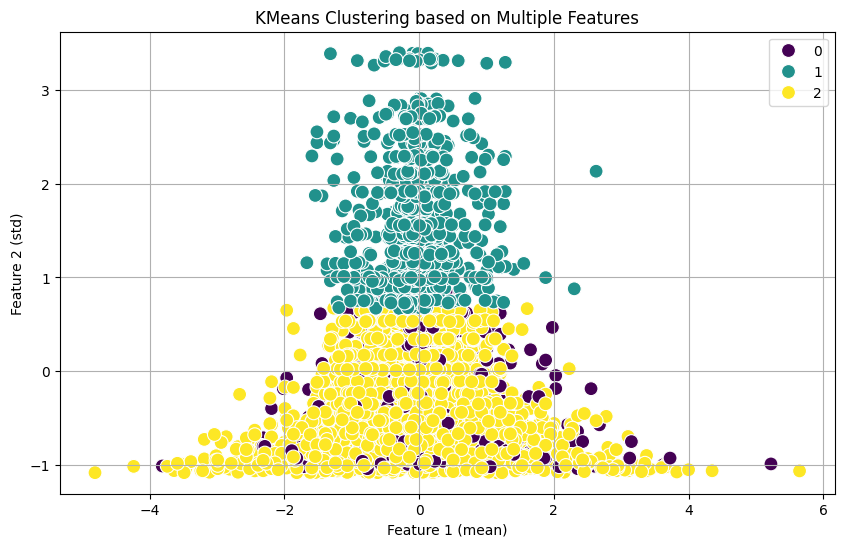

KMeans Cluster Centers (in scaled values):
[[ 0.0815529  -0.37127316 -0.4603325   0.44827768 -0.45434338 -1.01882169
  -1.06379361 -0.72361622  0.06091976 -0.3898546  -1.12893537  1.15411207
  -0.31441691  0.        ]
 [-0.03651603  1.65470697  1.66183335 -1.66416317  1.66309131 -0.39298336
  -0.09665203  1.26590326 -1.44615906  1.63847756 -0.22040943  0.21001819
   1.64312216  0.        ]
 [-0.03088918 -0.46009035 -0.41314048  0.42082505 -0.4169989   0.72859907
   0.63416615 -0.10605211  0.5495577  -0.44314475  0.72055691 -0.73044879
  -0.48722425  0.        ]]


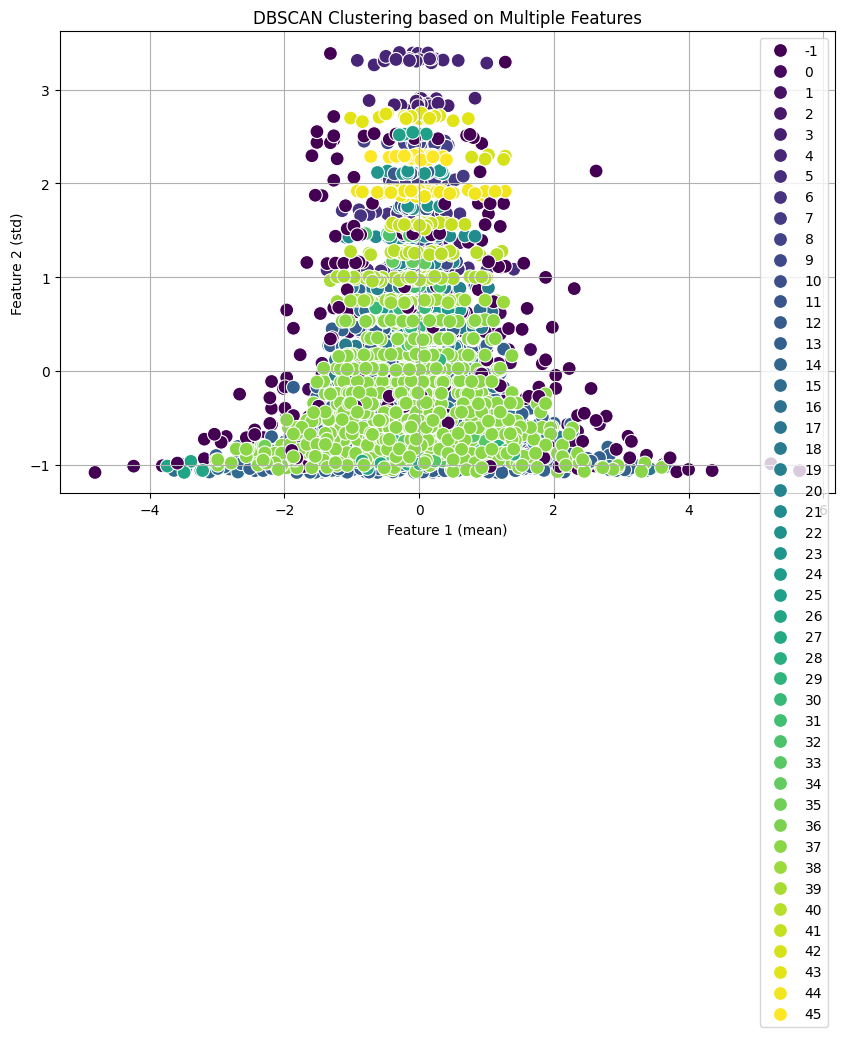


KMeans Cluster Summary:
   Cluster  Count
0        0    969
1        1    699
2        2   1732

DBSCAN Cluster Summary:
    Cluster  Count
0        -1    188
1         0    798
2         1     40
3         2     35
4         3     19
5         4     24
6         5     41
7         6     34
8         7     25
9         8     25
10        9     12
11       10     15
12       11     14
13       12      5
14       13    801
15       14     13
16       15      9
17       16     19
18       17      7
19       18    176
20       19     16
21       20     13
22       21     19
23       22     16
24       23     15
25       24     14
26       25     11
27       26      5
28       27     15
29       28     11
30       29     10
31       30      6
32       31      5
33       32      6
34       33     23
35       34      6
36       35      5
37       36      8
38       37    645
39       38     40
40       39     45
41       40     39
42       41     28
43       42      5
44       43     29
45  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 数据加载和预处理 (模拟特征数据)

# 2. 选择多个特征进行聚类分析 (这里使用 'mean', 'std', 'range' 作为例子)
X1 = X[['mean', 'std', 'max', 'min', 'range', 'skew',	'kurtosis',	'max_gradient',	'min_gradient',	'fft_power_sum', 'fft_entropy',	'fft_kurtosis',	'fft_max_val', 'fft_max_freq']].values

# 3. 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

### 4. KMeans 聚类 ###
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 5. 可视化 KMeans 聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis', s=100, legend='full')
plt.title('KMeans Clustering based on Multiple Features')
plt.xlabel('Feature 1 (mean)')
plt.ylabel('Feature 2 (std)')
plt.grid(True)
plt.show()

# 输出 KMeans 聚类中心
print("KMeans Cluster Centers (in scaled values):")
print(kmeans.cluster_centers_)

### 6. DBSCAN 聚类 ###
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# 7. 可视化 DBSCAN 聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan_labels, palette='viridis', s=100, legend='full')
plt.title('DBSCAN Clustering based on Multiple Features')
plt.xlabel('Feature 1 (mean)')
plt.ylabel('Feature 2 (std)')
plt.grid(True)
plt.show()

# 8. 查看聚类结果摘要
unique_labels_kmeans, counts_kmeans = np.unique(kmeans_labels, return_counts=True)
cluster_summary_kmeans = pd.DataFrame({'Cluster': unique_labels_kmeans, 'Count': counts_kmeans})
print("\nKMeans Cluster Summary:")
print(cluster_summary_kmeans)

unique_labels_dbscan, counts_dbscan = np.unique(dbscan_labels, return_counts=True)
cluster_summary_dbscan = pd.DataFrame({'Cluster': unique_labels_dbscan, 'Count': counts_dbscan})
print("\nDBSCAN Cluster Summary:")
print(cluster_summary_dbscan)

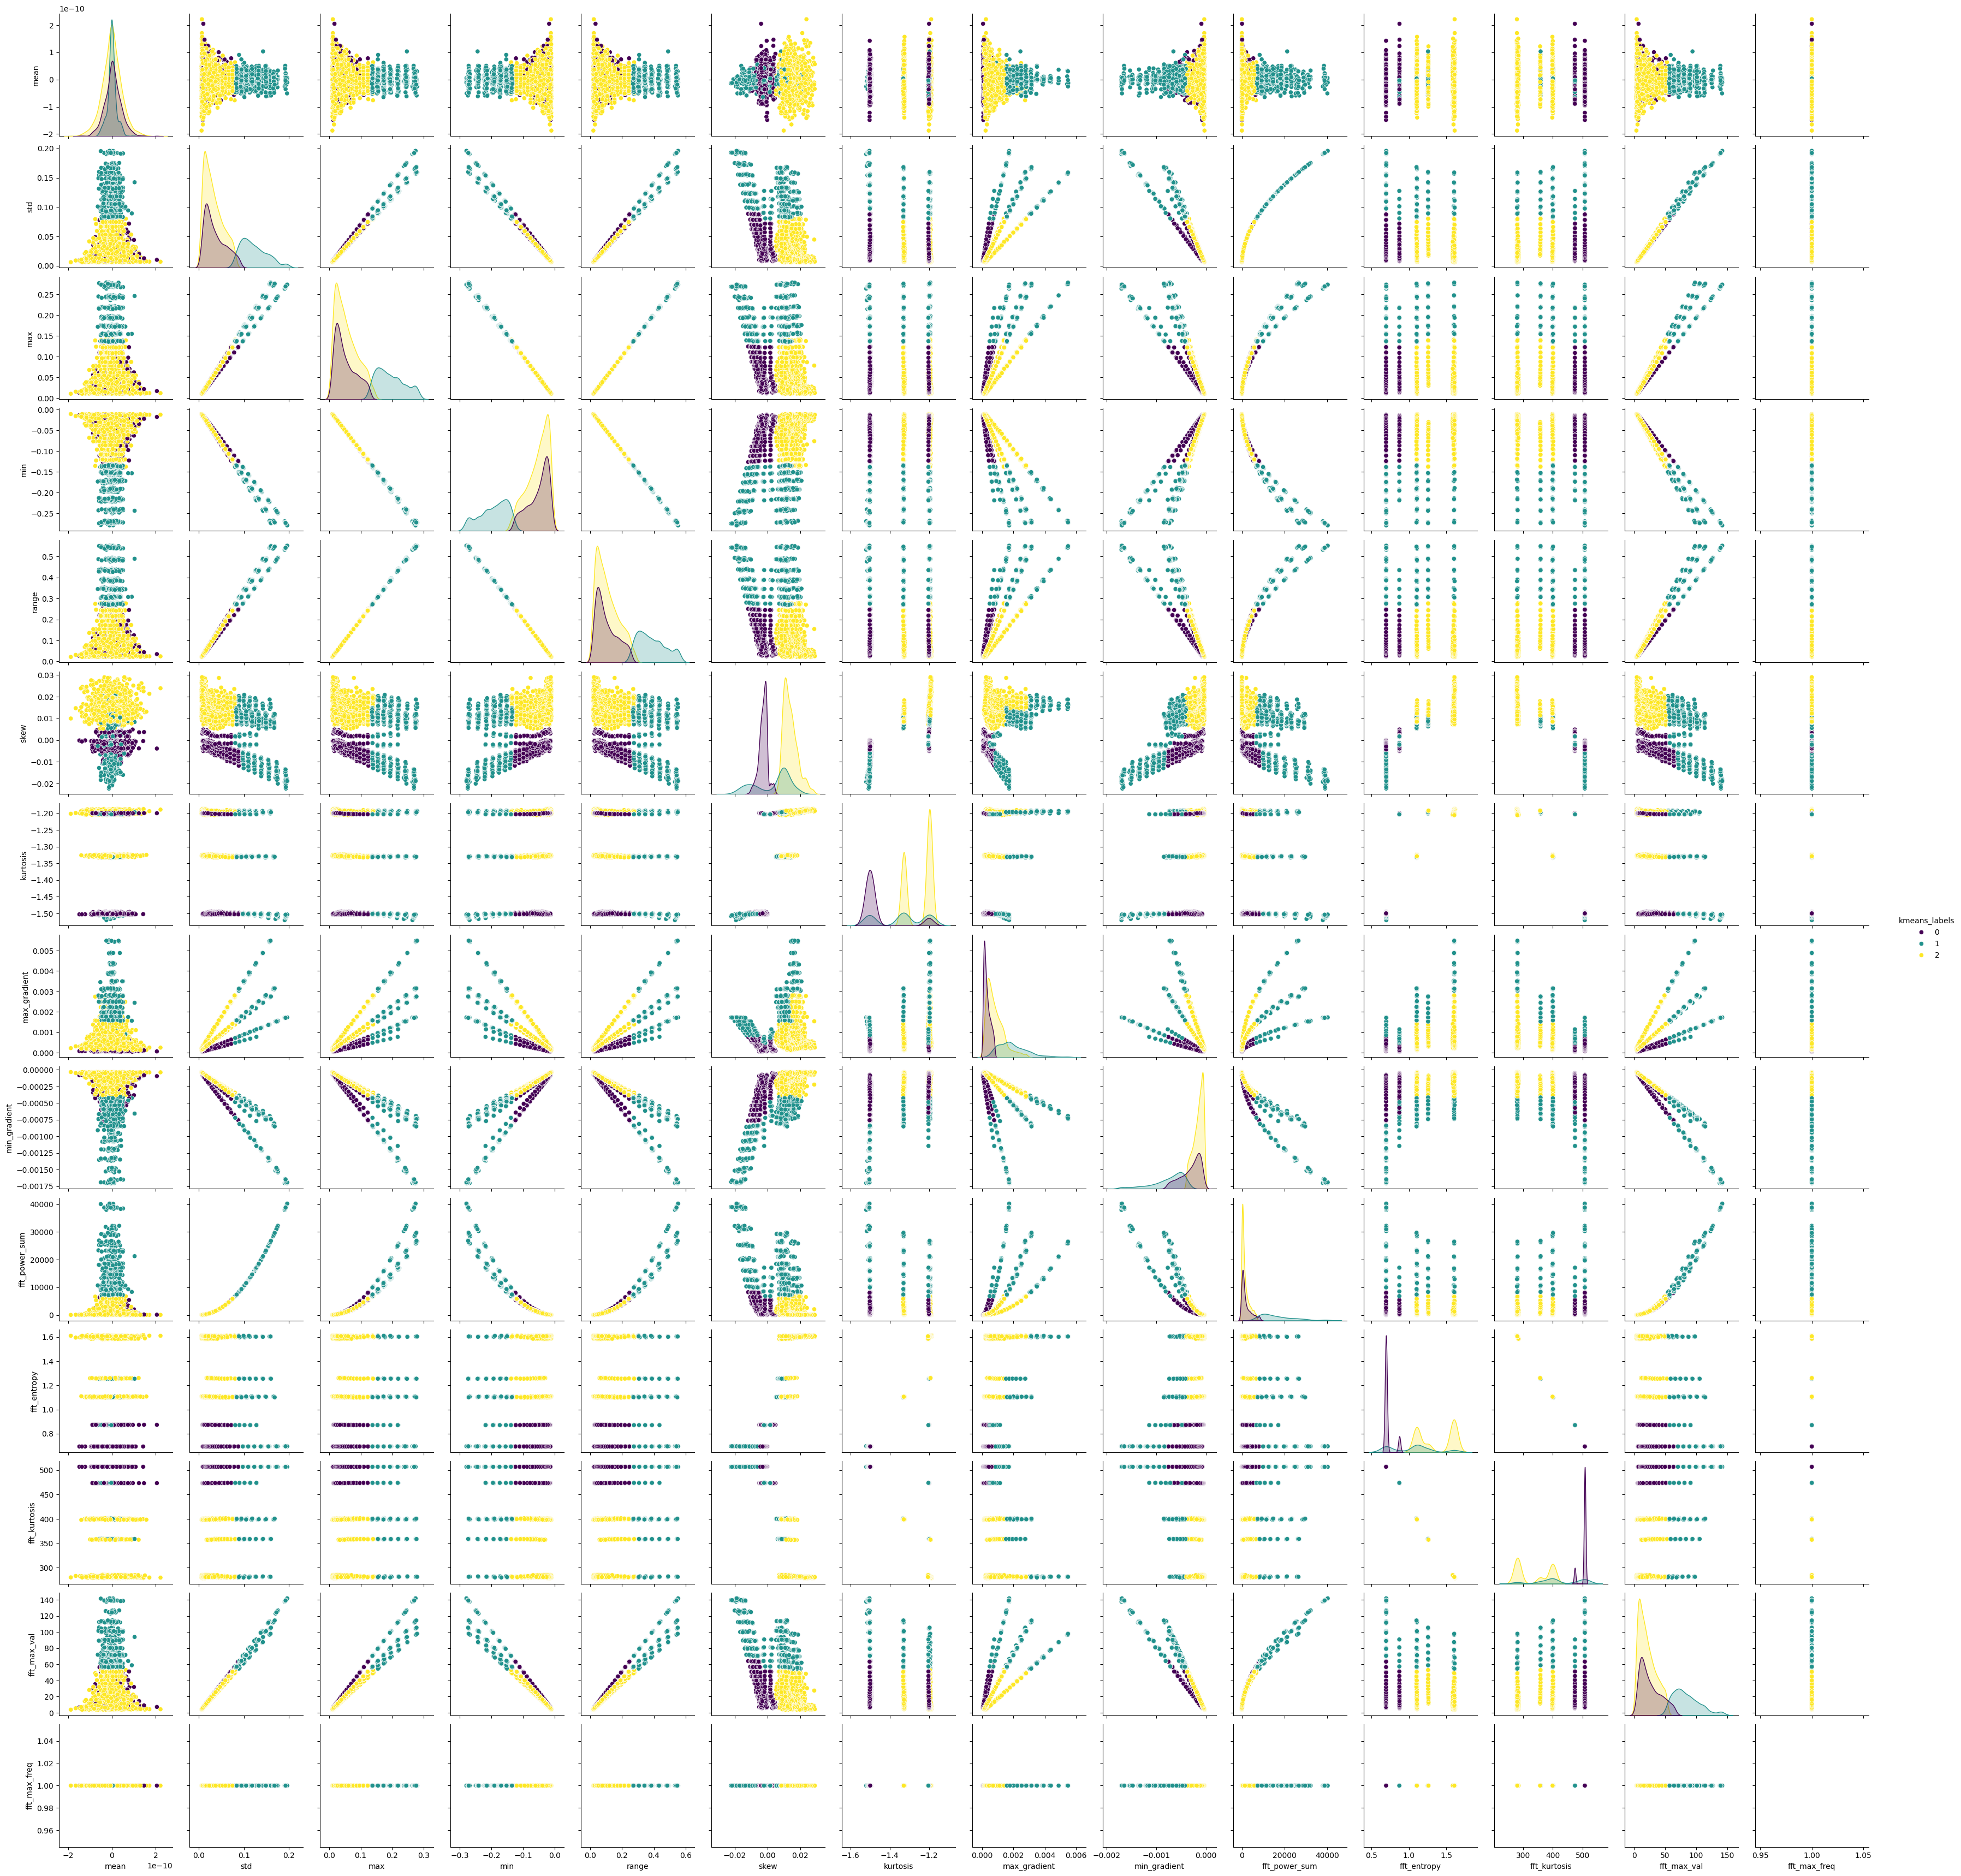

In [ ]:
import seaborn as sns
import pandas as pd

# 将聚类结果添加到原数据中，方便可视化
X['kmeans_labels'] = kmeans_labels

# 使用pairplot展示多个特征间的关系
sns.pairplot(X, vars=['mean', 'std', 'max', 'min', 'range', 'skew',	'kurtosis',	'max_gradient',	'min_gradient',	'fft_power_sum', 'fft_entropy',	'fft_kurtosis',	'fft_max_val', 'fft_max_freq'], hue='kmeans_labels', palette='viridis')
plt.show()


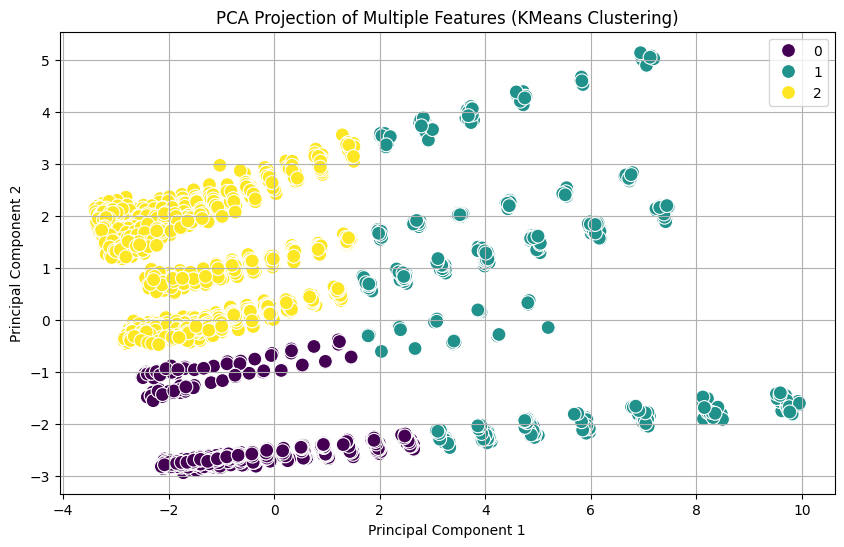

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 对数据进行 PCA 降维到 2 维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 可视化 PCA 降维后的结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=100, legend='full')
plt.title('PCA Projection of Multiple Features (KMeans Clustering)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D 可视化三个特征
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制 3D 散点图
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=kmeans_labels, cmap='viridis', s=70)

# 设置轴标签
ax.set_xlabel('Feature 1 (mean)')
ax.set_ylabel('Feature 2 (std)')
ax.set_zlabel('Feature 3 (range)')
ax.set_title('3D Visualization of Clustering (KMeans)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


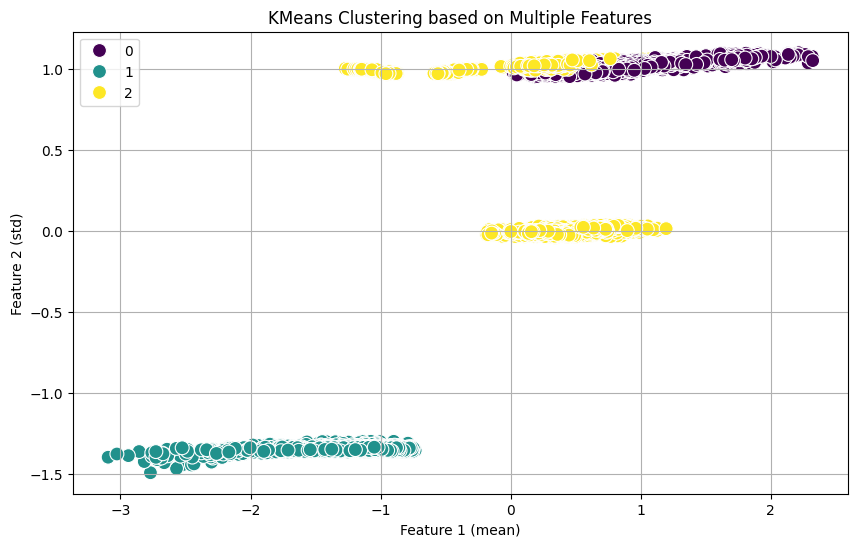

KMeans Cluster Centers (in scaled values):
[[ 0.99407481  1.0207504   1.36854053 -1.33748143]
 [-1.24367445 -1.34647548 -1.18872296  1.19895896]
 [ 0.28079236  0.34158336 -0.01495167 -0.01393365]]


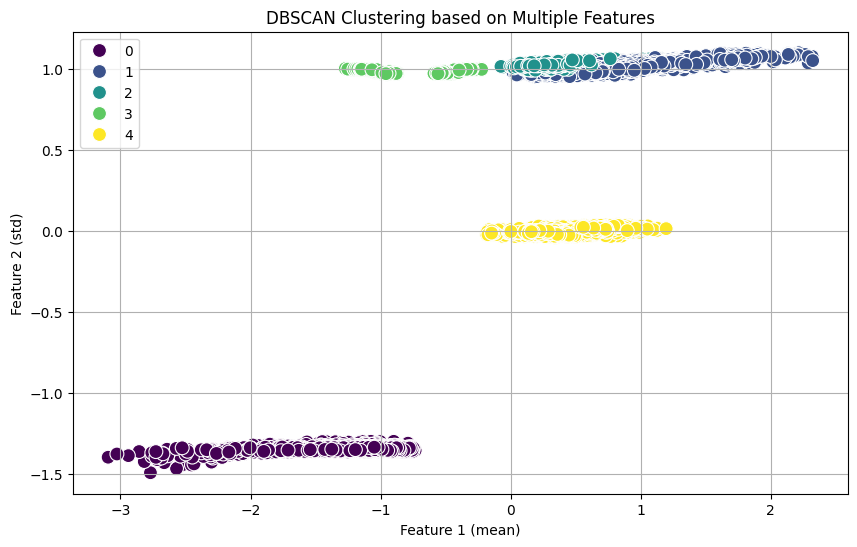


KMeans Cluster Summary:
   Cluster  Count
0        0    942
1        1   1067
2        2   1391

DBSCAN Cluster Summary:
   Cluster  Count
0        0   1067
1        1    941
2        2    307
3        3    164
4        4    921


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 数据加载和预处理 (模拟特征数据)

# 2. 选择多个特征进行聚类分析 (这里使用 'mean', 'std', 'range' 作为例子)
X1 = X[['skew',	'kurtosis',	'fft_entropy',	'fft_kurtosis']].values

# 3. 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

### 4. KMeans 聚类 ###
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 5. 可视化 KMeans 聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis', s=100, legend='full')
plt.title('KMeans Clustering based on Multiple Features')
plt.xlabel('Feature 1 (mean)')
plt.ylabel('Feature 2 (std)')
plt.grid(True)
plt.show()

# 输出 KMeans 聚类中心
print("KMeans Cluster Centers (in scaled values):")
print(kmeans.cluster_centers_)

### 6. DBSCAN 聚类 ###
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# 7. 可视化 DBSCAN 聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan_labels, palette='viridis', s=100, legend='full')
plt.title('DBSCAN Clustering based on Multiple Features')
plt.xlabel('Feature 1 (mean)')
plt.ylabel('Feature 2 (std)')
plt.grid(True)
plt.show()

# 8. 查看聚类结果摘要
unique_labels_kmeans, counts_kmeans = np.unique(kmeans_labels, return_counts=True)
cluster_summary_kmeans = pd.DataFrame({'Cluster': unique_labels_kmeans, 'Count': counts_kmeans})
print("\nKMeans Cluster Summary:")
print(cluster_summary_kmeans)

unique_labels_dbscan, counts_dbscan = np.unique(dbscan_labels, return_counts=True)
cluster_summary_dbscan = pd.DataFrame({'Cluster': unique_labels_dbscan, 'Count': counts_dbscan})
print("\nDBSCAN Cluster Summary:")
print(cluster_summary_dbscan)

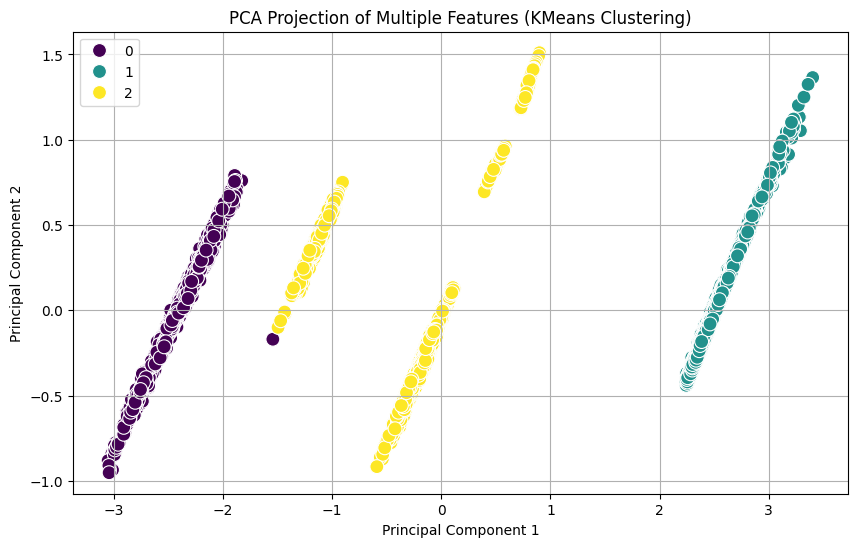

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 对数据进行 PCA 降维到 2 维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 可视化 PCA 降维后的结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=100, legend='full')
plt.title('PCA Projection of Multiple Features (KMeans Clustering)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

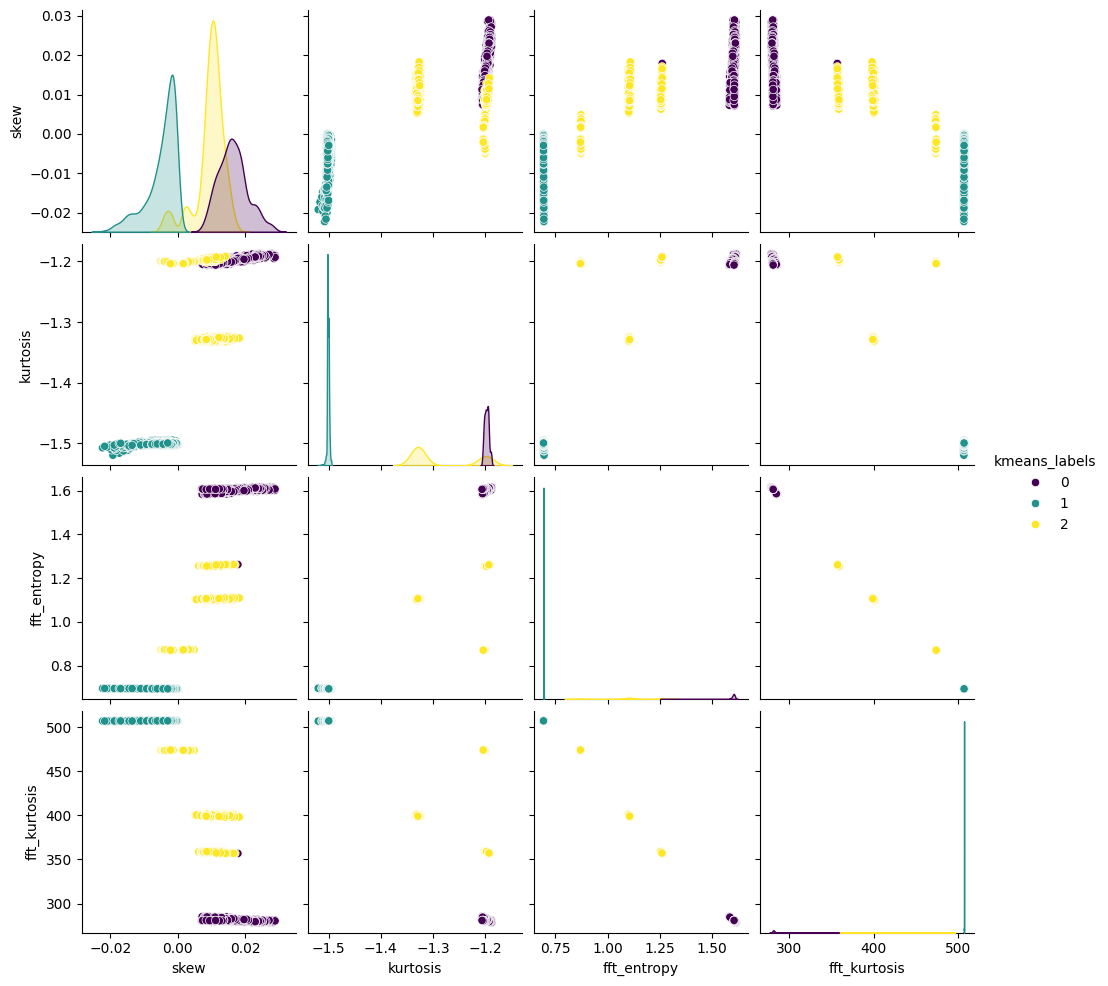

In [ ]:
import seaborn as sns
import pandas as pd

# 将聚类结果添加到原数据中，方便可视化
X['kmeans_labels'] = kmeans_labels

# 使用pairplot展示多个特征间的关系
sns.pairplot(X, vars=['skew',	'kurtosis',	'fft_entropy',	'fft_kurtosis'], hue='kmeans_labels', palette='viridis')
plt.show()

**问题一 励磁波形分类**

请利用附件一中磁通密度数据，首先分析磁通密度的分布特征及不同波形的形状特征，提取出反映磁通密度分布及波形的形状特征变量；然后利用这些特征变量建立分类模型，识别出励磁的三种波形，分析分类模型的合理性及有效性；并对附件二中的样本识别出相应波形，把分类结果填入附件四（Excel 表格）中第 2 列，要求：

（1）
按样本序号填入相应分类结果，只填数字，1 表示正弦波，2 表示三角波，3 表示梯形波，比如：附件二中第 1 个样品分类结果是三角波，在第 2 列样本序号为 1 对应行就填数字 2；

（2）
结果填入附件四后，保留原文件名，以附件材料上传；

（3）统计出附件二中三种波形的各自数量，呈现在论文正文中；

（4）特别把附件二中样本序号为：1、5、15、25、35、45、55、65、75、80 的分类结果，以表格形式呈现在论文正文中。

In [ ]:
# 数据处理与加载
def rename_columns(data, is_test=False):
    """重命名训练集或测试集的列"""
    if not is_test:
        columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(1024)]
    else:
        columns = ['serial number', 'T/oC', 'f/Hz', 'Core material'] + [f'B(t)_{i}' for i in range(1024)]

    data.columns = columns
    return data

# 波形分类为数值（自定义映射）
def custom_waveform_mapping(data):
    mapping = {'正弦波': 1, '三角波': 2, '梯形波': 3}
    data['waveform'] = data['waveform'].map(mapping)
    return data

# 读取并处理数据
def load_and_preprocess_data(filepath, is_test=False):
    """根据是否为测试集加载并处理数据"""
    if not is_test:
        sheet_names = ['材料1', '材料2', '材料3', '材料4']
        data_frames = [rename_columns(pd.read_excel(filepath, sheet_name=sheet)) for sheet in sheet_names]
        data = pd.concat(data_frames, axis=0, ignore_index=True)

        # # 波形分类为数值
        # le = LabelEncoder()
        # data['waveform'] = le.fit_transform(data['waveform'])

        # # 查看类别与数值映射
        # label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
        # print("类别到数值的映射:", label_mapping)

        # # 如果需要反向映射
        # reverse_mapping = dict(zip(range(len(le.classes_)), le.classes_))
        # print("数值到类别的映射:", reverse_mapping)

        # 自定义波形映射
        data = custom_waveform_mapping(data)

        print(data.info())
        print("波形类别分布:", data['waveform'].value_counts())

        data.to_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_train_data.csv', index=False)

    else:
        data = rename_columns(pd.read_excel(filepath), is_test=True)
        data.to_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_test_data.csv', index=False)

    return data

train_filepath = '/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx'
train_data = load_and_preprocess_data(train_filepath)
test_filepath = '/content/drive/MyDrive/loss modelling of magnetic components/test1.xlsx'
test_data = load_and_preprocess_data(test_filepath, is_test=True)

In [ ]:
# @title
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from scipy.stats import skew, kurtosis
from scipy.fft import fft

# 特征提取
def extract_features(X):
    features = pd.DataFrame()

    # 1. 时域统计特征
    features['mean'] = np.mean(X, axis=1)
    features['std'] = np.std(X, axis=1)
    features['max'] = np.max(X, axis=1)
    features['min'] = np.min(X, axis=1)
    features['range'] = features['max'] - features['min']
    features['skew'] = skew(X, axis=1)
    features['kurtosis'] = kurtosis(X, axis=1)

    # 2. 斜率特征（梯度）
    def compute_gradient(row):
        gradient = np.gradient(row)
        return np.max(gradient), np.min(gradient)

    gradients = np.apply_along_axis(compute_gradient, 1, X)
    features['max_gradient'] = gradients[:, 0]
    features['min_gradient'] = gradients[:, 1]

    # 3. 频域特征（傅里叶变换）
    fft_vals = np.abs(fft(X, axis=1))
    psd = fft_vals ** 2  # Power Spectrum Density
    features['fft_power_sum'] = np.sum(psd, axis=1)

    psd_norm = psd / np.sum(psd, axis=1, keepdims=True)
    features['fft_entropy'] = -np.sum(psd_norm * np.log(psd_norm + 1e-8), axis=1)

    features['fft_kurtosis'] = kurtosis(fft_vals, axis=1)
    features['fft_max_val'] = np.max(fft_vals, axis=1)
    features['fft_max_freq'] = np.argmax(fft_vals, axis=1)

    return features

# 特征选择
def select_important_features(X_train, y_train, X_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    selector = SelectFromModel(clf, threshold='mean', prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    print(f"Original number of features: {X_train.shape[1]}")
    print(f"Reduced number of features: {X_train_selected.shape[1]}")

    selected_features = X_train.columns[selector.get_support()].tolist()
    print("Selected features: ", selected_features)

    return X_train_selected, X_test_selected, selector

# 预测并输出结果
def predict_on_test_data(test_data, selector, clf_selected):
    X_test_raw = test_data.iloc[:, 4:].values
    X_test_features = extract_features(X_test_raw)
    X_test_selected = selector.transform(X_test_features)

    test_data['waveform_prediction'] = clf_selected.predict(X_test_selected)
    test_data[['serial number', 'waveform_prediction']].to_csv('test_predictions.csv', index=False)
    print(test_data[['serial number', 'waveform_prediction']].head())

# 主流程
def main():
    # 提取特征
    X_raw = train_data.iloc[:, 4:].values  # 磁通密度数据
    X = extract_features(X_raw)
    y = train_data['waveform']

    # 分割数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特征选择
    X_train_selected, X_test_selected, selector = select_important_features(X_train, y_train, X_test)

    # 在特征选择后的数据上训练模型
    clf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_selected.fit(X_train_selected, y_train)
    y_pred_selected = clf_selected.predict(X_test_selected)

    # 输出特征选择后的模型性能
    print("Classification Report after Feature Selection:")
    print(classification_report(y_test, y_pred_selected))

    # 测试集预测
    predict_on_test_data(test_data, selector, clf_selected)

# 加载和处理训练集数据
train_data = pd.read_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_test_data.csv')

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Original number of features: 14
Reduced number of features: 4
Selected features:  ['skew', 'kurtosis', 'fft_entropy', 'fft_kurtosis']
Classification Report after Feature Selection:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       797
           2       1.00      1.00      1.00       977
           3       1.00      1.00      1.00       706

    accuracy                           1.00      2480
   macro avg       1.00      1.00      1.00      2480
weighted avg       1.00      1.00      1.00      2480

   serial number  waveform_prediction
0              1                    2
1              2                    2
2              3                    2
3              4                    2
4              5                    2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


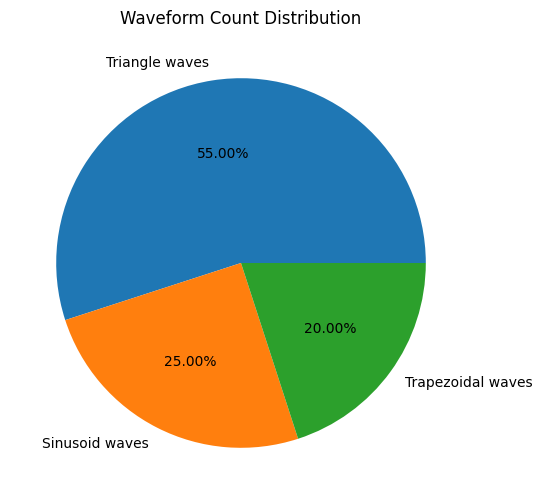

In [ ]:
import matplotlib.pyplot as plt

waveform_labels = {2: 'Triangle waves', 3: 'Trapezoidal waves', 1: 'Sinusoid waves'}

# 重新计算波形的分布
waveform_count_distribution = test_data['waveform_prediction'].value_counts()

# 使用字典将数值映射为波形名称
waveform_count_distribution.index = waveform_count_distribution.index.map(waveform_labels)

# 绘制饼图
plt.figure(figsize=(8, 6))
waveform_count_distribution.plot.pie(autopct='%1.2f%%', labels=waveform_count_distribution.index)
plt.title('Waveform Count Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/loss modelling of magnetic components/test_predictions.csv')
test_data['waveform_prediction'].value_counts()

waveform_prediction
0    44
2    20
1    16
Name: count, dtype: int64

**问题二 斯坦麦茨方程（Steinmetz-equation）修正**

请通过分析斯坦麦茨方程，在同一种磁芯材料、正弦波形下，对于不同温度变化，磁芯损耗预测效果存在的差异性，构造一种可适用于不同温度变化的磁芯损耗修正方程 （即在原斯坦麦茨方程基础上，增加温度这个因素，以适应不同温度变化，使磁芯损耗预测效果更好）；并以附件一材料 1 中正弦波形的数据为例，分析你构造的修正方程与斯坦麦茨方程， 他们预测磁芯损耗的效果（误差）哪个更好？



Levenberg-Marquardt 方法

处理复杂数据：它结合了梯度下降和牛顿法的优点，能在复杂非线性模型上取得较好的拟合效果。

更快收敛：对于曲线拟合，特别是多参数的情况，它通常能更快收敛到更优的解。

In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=e3c9a99918b3dc547bee7e711aede8277f601b1fea1e4170c191e016c8c34744
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


<ipython-input-20-f1c5d55b4f35>:11: RuntimeWarning: overflow encountered in power
  return k1 * (f ** alpha1) * (Bm ** beta1)
<ipython-input-20-f1c5d55b4f35>:16: RuntimeWarning: overflow encountered in power
  return k1 * (f ** alpha1) * (Bm ** beta1) * (1 + (T / T0) * c)


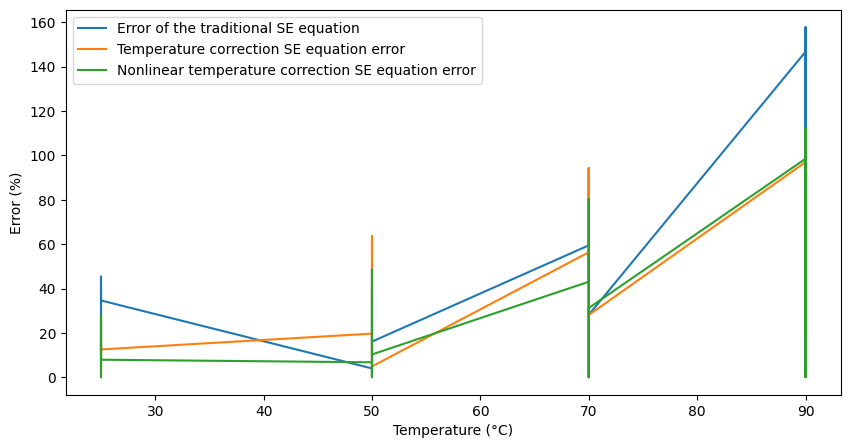

传统斯坦麦茨方程拟合误差: Error=35.662632508784206
温度修正斯坦麦茨方程拟合误差: Error=25.62669400895283
非线性温度修正斯坦麦茨方程拟合误差: Error=22.383038602866833
传统斯坦麦茨方程拟合系数: k1=1.4997412312561496, alpha1=1.4296345971294708, beta1=2.4712537611775547
温度修正斯坦麦茨方程拟合系数: k1=1.8711696710735672, alpha1=1.4385471889670063, beta1=2.432449958820983, c=-0.13541803655236512
非线性温度修正斯坦麦茨方程拟合系数: k1=-67.0285636897727, alpha1=1.4634841014826487, beta1=2.4485146373656312, c1=-0.019397128225584648, c2=-0.40175674926083055


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from pyswarm import pso
from sklearn.preprocessing import StandardScaler

# 斯坦麦茨方程
def steinmetz(f_Bm, k1, alpha1, beta1):
    f, Bm = f_Bm
    return k1 * (f ** alpha1) * (Bm ** beta1)

# 温度修正斯坦麦茨方程
def steinmetz_with_temp(f_Bm_T, k1, alpha1, beta1, c, T0=25):
    f, Bm, T = f_Bm_T
    return k1 * (f ** alpha1) * (Bm ** beta1) * (1 + (T / T0) * c)

# 非线性温度修正斯坦麦茨方程
def steinmetz_with_nonlinear_temp(f_Bm_T, k1, alpha1, beta1, c1, c2, T0=25):
    f, Bm, T = f_Bm_T
    return k1 * (f ** alpha1) * (Bm ** beta1) * (c1 * (T / T0) ** c2)

# 目标函数
def objective_func(params, func, f, Bm, T, P_real):
    f_Bm_T = (f, Bm, T) if T is not None else (f, Bm)
    return (np.abs(P_real - func(f_Bm_T, *params)) / P_real).mean()

# PSO 优化函数
def pso_optimize(func, bounds, f, Bm, T, P_real, swarmsize=100, maxiter=50000):
    lb, ub = zip(*bounds)
    optimal_params, _ = pso(objective_func, lb, ub, args=(func, f, Bm, T, P_real), swarmsize=swarmsize, maxiter=maxiter)
    return optimal_params

# 主函数，处理模型拟合
def fit_steinmetz_models(X, y):
    f = X[:, 0]  # 频率
    Bm = X[:, 1]  # 磁通密度
    T = X[:, 2]  # 温度

    # 传统斯坦麦茨方程
    # bounds_se = [(1e-6, 1), (1, 3), (2, 3)]
    # initial_guess_se = pso_optimize(steinmetz, bounds_se, f, Bm, None, y)
    popt_se, _ = curve_fit(steinmetz, (f, Bm), y, p0=[1e-6, 1.5, 2.5])

    # 温度修正斯坦麦茨方程
    # bounds_tse = [(1e-6, 1), (1, 3), (2, 3), (-5, 5)]
    # initial_guess_tse = pso_optimize(steinmetz_with_temp, bounds_tse, f, Bm, T, y)
    popt_tse, _ = curve_fit(steinmetz_with_temp, (f, Bm, T), y, p0=[1e-6, 1.5, 2.5, 1.5])

    # 非线性温度修正斯坦麦茨方程
    # bounds_tse_nonlinear = [(1e-6, 1), (1, 3), (2, 3), (-5, 5), (-5, 5)]
    # initial_guess_tse_nonlinear = pso_optimize(steinmetz_with_nonlinear_temp, bounds_tse_nonlinear, f, Bm, T, y)
    popt_tse_nonlinear, _ = curve_fit(steinmetz_with_nonlinear_temp, (f, Bm, T), y, p0=[-1000, 1.5, 2.5, -0.05, 0.625])

    return popt_se, popt_tse, popt_tse_nonlinear

# 预测与误差分析
def predict_and_plot(X, y, popt_se, popt_tse, popt_tse_nonlinear):
    f = X[:, 0]
    Bm = X[:, 1]
    T = X[:, 2]

    P_pred_se = steinmetz((f, Bm), *popt_se)
    P_pred_tse = steinmetz_with_temp((f, Bm, T), *popt_tse)
    P_pred_tse_nonlinear = steinmetz_with_nonlinear_temp((f, Bm, T), *popt_tse_nonlinear)

    error_se = np.abs(y - P_pred_se) / y * 100
    error_tse = np.abs(y - P_pred_tse) / y * 100
    error_tse_nonlinear = np.abs(y - P_pred_tse_nonlinear) / y * 100

    plt.figure(figsize=(10, 5))
    plt.plot(X[:, 2], error_se, label='Error of the traditional SE equation')
    plt.plot(X[:, 2], error_tse, label='Temperature correction SE equation error')
    plt.plot(X[:, 2], error_tse_nonlinear, label='Nonlinear temperature correction SE equation error')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

    print(f"传统斯坦麦茨方程拟合误差: Error={error_se.mean()}")
    print(f"温度修正斯坦麦茨方程拟合误差: Error={error_tse.mean()}")
    print(f"非线性温度修正斯坦麦茨方程拟合误差: Error={error_tse_nonlinear.mean()}")
    print(f"传统斯坦麦茨方程拟合系数: k1={popt_se[0]}, alpha1={popt_se[1]}, beta1={popt_se[2]}")
    print(f"温度修正斯坦麦茨方程拟合系数: k1={popt_tse[0]}, alpha1={popt_tse[1]}, beta1={popt_tse[2]}, c={popt_tse[3]}")
    print(f"非线性温度修正斯坦麦茨方程拟合系数: k1={popt_tse_nonlinear[0]}, alpha1={popt_tse_nonlinear[1]}, beta1={popt_tse_nonlinear[2]}, c1={popt_tse_nonlinear[3]}, c2={popt_tse_nonlinear[4]}")

# 主程序调用示例
if __name__ == "__main__":
    # data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx')
    # data.columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(1024)]
    # data = data[data['waveform'] == '正弦波']
    # f = data['f/Hz'].values
    # Bm = np.max(data.iloc[:, 4:].values, axis=1)
    # T = data['T/oC'].values
    # P_real = data['P_w/m3'].values

    # # 处理为输入特征和目标变量
    # X = np.column_stack((f, Bm, T))
    # y = P_real

    # 拟合三种斯坦麦茨方程
    popt_se, popt_tse, popt_tse_nonlinear = fit_steinmetz_models(X, y)

    # 进行预测和误差分析
    predict_and_plot(X, y, popt_se, popt_tse, popt_tse_nonlinear)


Iteration 1/1000, Global Best Value: 0.451133
Iteration 501/1000, Global Best Value: 0.263048
Iteration 1/1000, Global Best Value: 0.505303
Iteration 501/1000, Global Best Value: 0.457995
Iteration 1/1000, Global Best Value: 0.351208
Iteration 501/1000, Global Best Value: 0.138000
steinmetz 的最优平均误差: 0.2630
steinmetz_with_temp 的最优平均误差: 0.4580
steinmetz_with_nonlinear_temp 的最优平均误差: 0.1380


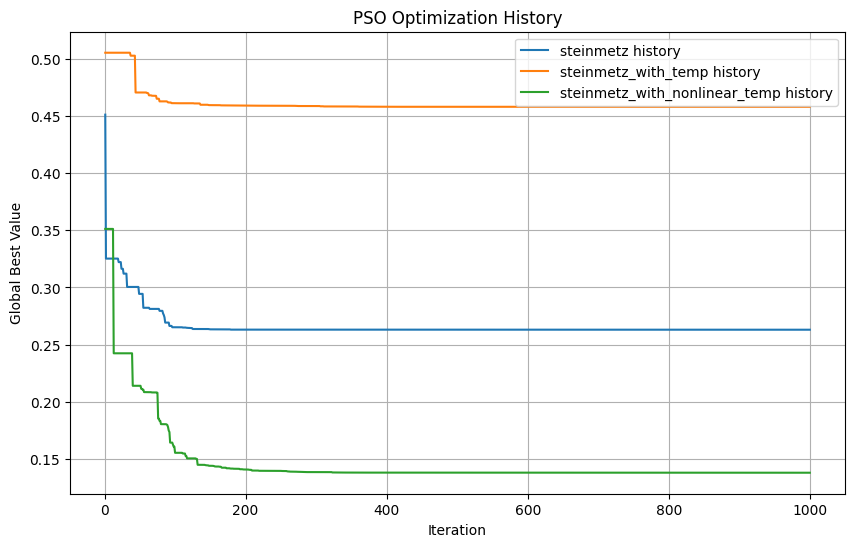

steinmetz 的最优拟合参数: [0.03056555 1.759005   2.54148716]
steinmetz_with_temp 的最优拟合参数: [0.00432871 1.92575606 2.56079509 0.30611419]
steinmetz_with_nonlinear_temp 的最优拟合参数: [ 0.10719651  1.57048942  2.57749262  4.94099064 -0.6247585 ]


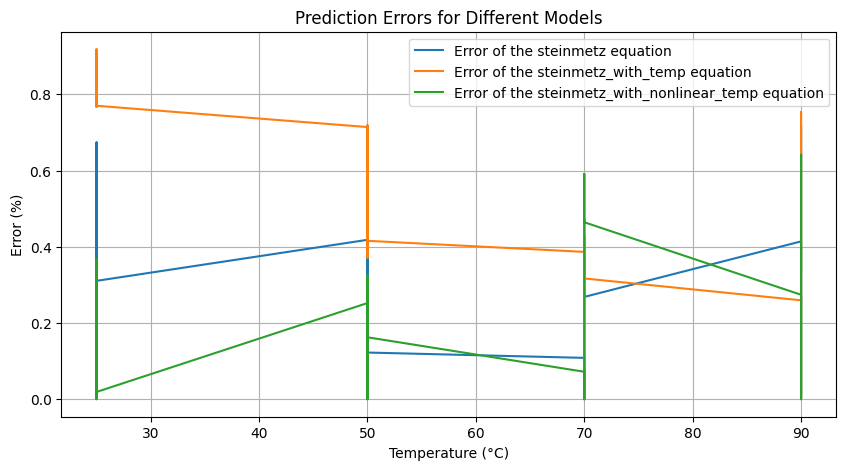

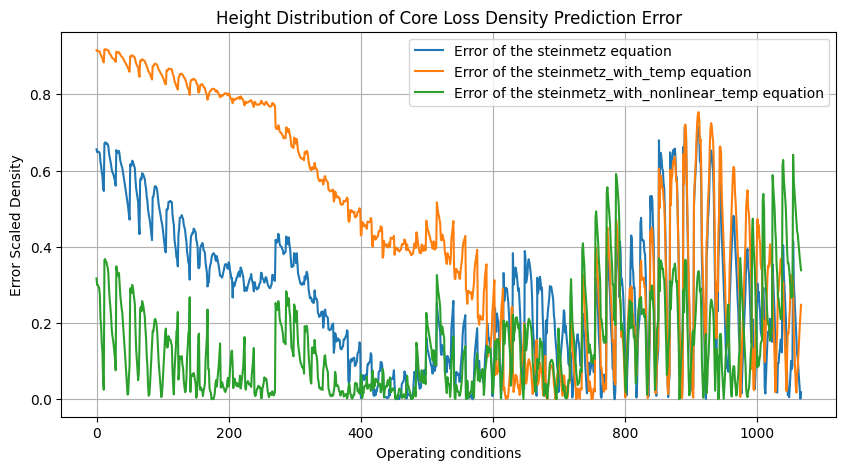

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pyswarm import pso

# 斯坦麦茨方程模型
def steinmetz(f_Bm, k1, alpha1, beta1):
    f, Bm = f_Bm
    return k1 * (f ** alpha1) * (Bm ** beta1)

def steinmetz_with_temp(f_Bm_T, k1, alpha1, beta1, c, T0=25):
    f, Bm, T = f_Bm_T
    return k1 * (f ** alpha1) * (Bm ** beta1) * (c * (T / T0))

def steinmetz_with_nonlinear_temp(f_Bm_T, k1, alpha1, beta1, c1, c2, T0=25):
    f, Bm, T = f_Bm_T
    # return k1 * (f ** alpha1) * (Bm ** beta1) * (c1 * (T / T0) ** c2)
    return k1 * (f ** alpha1) * (Bm ** beta1) * (c1 * (T / T0) ** c2 )

# 自定义 PSO 类
class EnhancedPSO:
    def __init__(self, func, lb, ub, args, swarmsize=50, maxiter=100,
                 inertia_weight=0.9, inertia_damp=0.99, c1=2.0, c2=2.0, seed=None):
        self.func = func
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.args = args
        self.swarmsize = swarmsize
        self.maxiter = maxiter
        self.inertia_weight = inertia_weight
        self.inertia_damp = inertia_damp
        self.c1 = c1
        self.c2 = c2
        self.history = []  # 记录每次迭代的全局最佳值
        self.best_positions = []  # 记录每次迭代的全局最佳位置

    def optimize(self):
        # np.random.seed(self.seed)
        dim = len(self.lb)
        swarm = np.random.uniform(self.lb, self.ub, (self.swarmsize, dim))
        velocity = np.zeros((self.swarmsize, dim))
        personal_best = np.copy(swarm)
        personal_best_value = np.array([self.func(p, *self.args) for p in swarm])
        global_best = personal_best[np.argmin(personal_best_value)]
        global_best_value = np.min(personal_best_value)

        for i in range(self.maxiter):
            for j in range(self.swarmsize):
                # 更新速度
                r1, r2 = np.random.rand(dim), np.random.rand(dim)
                velocity[j] = (self.inertia_weight * velocity[j] +
                               self.c1 * r1 * (personal_best[j] - swarm[j]) +
                               self.c2 * r2 * (global_best - swarm[j]))

                # 更新位置
                swarm[j] += velocity[j]
                swarm[j] = np.clip(swarm[j], self.lb, self.ub)

                # 计算新的目标函数值
                current_value = self.func(swarm[j], *self.args)

                # 更新个体最佳位置
                if current_value < personal_best_value[j]:
                    personal_best[j] = swarm[j]
                    personal_best_value[j] = current_value

                # 更新全局最佳位置
                if current_value < global_best_value:
                    global_best = swarm[j]
                    global_best_value = current_value

            # 动态调整惯性权重
            self.inertia_weight *= self.inertia_damp

            # 记录每次迭代的全局最佳值和位置
            self.history.append(global_best_value)
            self.best_positions.append(global_best)

            if i % 500 == 0:
              print(f"Iteration {i+1}/{self.maxiter}, Global Best Value: {global_best_value:.6f}")

        return global_best, global_best_value

# 目标函数，计算误差（使用向量化）
def objective_func(params, func, f, Bm, T, P_real):
    if T is not None:
        f_Bm_T = np.vstack((f, Bm, T)).T
    else:
        f_Bm_T = np.vstack((f, Bm)).T

    # 批量计算预测值
    P_pred = func(f_Bm_T.T, *params)

    # 计算误差并返回平均值
    return np.mean(np.abs(P_real - P_pred) / P_real)

# PSO 优化过程
def pso_optimize(func, lb, ub, f, Bm, T, P_real, swarmsize=100, maxiter=1000):
    # 确定是否传递 T
    if len(lb) == 3:
        T = None  # 对于传统斯坦麦茨方程，T 为 None
    pso_optimizer = EnhancedPSO(objective_func, lb, ub, args=(func, f, Bm, T, P_real), swarmsize=swarmsize, maxiter=maxiter)
    best_solution, best_value = pso_optimizer.optimize()
    # popt_tse, _ = curve_fit(objective_func, (f, Bm, T), y, p0=[1e-6, 1.5, 2.5, 1.5])

    return best_solution, pso_optimizer.history  # 返回最优解和优化历史

# 拟合三种斯坦麦茨方程
def fit_steinmetz_models(f, Bm, T, P_real):
    bounds = (-1, 5)
    models = {
        'steinmetz': (steinmetz, [bounds[0]] * 3, [bounds[1]] * 3),
        'steinmetz_with_temp': (steinmetz_with_temp, [bounds[0]] * 4, [bounds[1]] * 4),
        'steinmetz_with_nonlinear_temp': (steinmetz_with_nonlinear_temp, [bounds[0]] * 5, [bounds[1]] * 5)
    }

    popt = {}
    history_dict = {}
    function = {}
    for model_name, (model_func, lb, ub) in models.items():
        initial_guess, history = pso_optimize(model_func, lb, ub, f, Bm, T, P_real)
        popt[model_name] = initial_guess
        history_dict[model_name] = history
        function[model_name] = model_func

    return popt, history_dict, function

# 可视化 PSO 优化历史
def plot_optimization_history(f, Bm, T, P_real, popt, history_dict, function):
    plt.figure(figsize=(10, 6))
    for model_name, history in history_dict.items():
        print(f"{model_name} 的最优平均误差: {min(history):.4f}")
        iterations = list(range(1, len(history) + 1))
        plt.plot(iterations, history, label=f'{model_name} history')

    plt.xlabel('Iteration')
    plt.ylabel('Global Best Value')
    plt.title('PSO Optimization History')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    for model_name, position in popt.items():
        print(f"{model_name} 的最优拟合参数: {position}")
        func = function[model_name]
        # 确定是否传递 T
        if model_name == 'steinmetz':
            f_Bm_T = np.vstack((f, Bm)).T
        else:
            f_Bm_T = np.vstack((f, Bm, T)).T

        # 批量计算预测值
        P_pred = func(f_Bm_T.T, *position)

        # 计算误差并返回平均值
        errors = np.abs(P_real - P_pred) / P_real

        plt.plot(T, errors, label=f"Error of the {model_name} equation")

    plt.xlabel('Temperature (°C)')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.title('Prediction Errors for Different Models')
    plt.grid()
    plt.show()

    # 绘制拟合结果与真实数据
    plt.figure(figsize=(10, 5))
    for model_name, position in popt.items():
        func = function[model_name]
        if model_name == 'steinmetz':
            f_Bm_T = np.vstack((f, Bm)).T
        else:
            f_Bm_T = np.vstack((f, Bm, T)).T
        P_pred = func(f_Bm_T.T, *position)
        errors = np.abs(P_real - P_pred) / P_real

        plt.plot(errors, label=f"Error of the {model_name} equation")

    # plt.plot(P_real, label="Real Core Loss")
    plt.xlabel('Operating conditions')
    plt.ylabel('Error Scaled Density')
    plt.legend()
    plt.title('Height Distribution of Core Loss Density Prediction Error')
    plt.grid()
    plt.show()

# 主程序调用示例
if __name__ == "__main__":
    # 数据加载
    # data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx')
    # data.columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(1024)]
    # data = data[data['waveform'] == '正弦波']
    # f = data['f/Hz'].values
    # Bm = np.max(data.iloc[:, 4:].values, axis=1)
    # T = data['T/oC'].values
    # P_real = data['P_w/m3'].values

    # 拟合模型
    popt, history_dict, function = fit_steinmetz_models(f, Bm, T, P_real)

    # 查看优化历史
    plot_optimization_history(f, Bm, T, P_real, popt, history_dict, function)


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx')
data.columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(1024)]
f = data['f/Hz'].values
Bm = np.max(data.iloc[:, 4:].values, axis=1)
P_real = data['P_w/m3'].values

popt_se, _ = curve_fit(steinmetz, (f, Bm), P_real)
P_pred_se = steinmetz((f, Bm), *popt_se)
(np.abs(P_real - P_pred_se) / P_real * 100).mean()

72.1357597679593

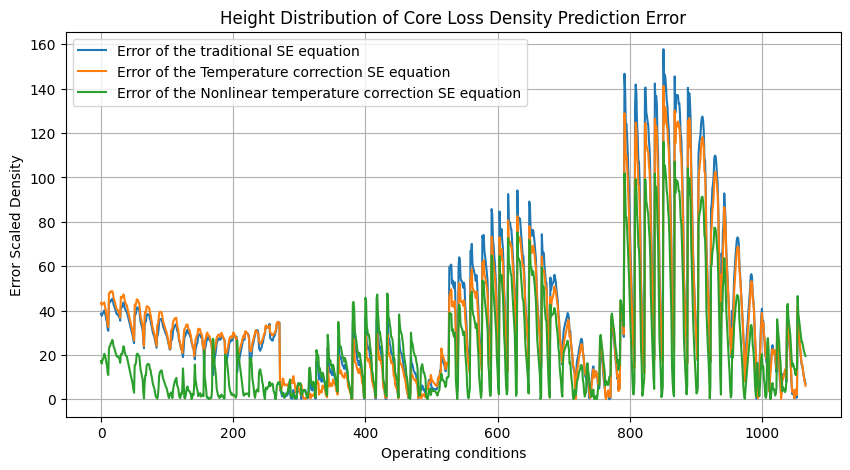

In [ ]:
# 绘制其他特征相对高度分布
plt.figure(figsize=(10, 5))
plt.plot(error_se, label='Error of the traditional SE equation')
plt.plot(error_tse, label='Error of the Temperature correction SE equation')
plt.plot(error_tse_nonlinear, label='Error of the Nonlinear temperature correction SE equation')
# 添加标题、标签和图例
plt.title('Height Distribution of Core Loss Density Prediction Error')
plt.xlabel('Operating conditions')
plt.ylabel('Error Scaled Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data

T/oC    f/Hz         P_w/m3 waveform    B(t)_0    B(t)_1    B(t)_2  \
0       25   50030    1997.955250      正弦波  0.000213  0.000389  0.000566   
1       25   50020    2427.749830      正弦波 -0.000551 -0.000358 -0.000165   
2       25   50020    3332.725760      正弦波 -0.003780 -0.003564 -0.003349   
3       25   50020    4502.908007      正弦波 -0.000511 -0.000267 -0.000023   
4       25   50030    6063.023248      正弦波  0.000458  0.000732  0.001007   
...    ...     ...            ...      ...       ...       ...       ...   
1062    90  316230   54682.608350      正弦波 -0.000427 -0.000156  0.000114   
1063    90  316230   71443.968180      正弦波 -0.001780 -0.001476 -0.001172   
1064    90  316230   94691.425060      正弦波 -0.000111  0.000231  0.000572   
1065    90  316230  123821.811900      正弦波  0.002825  0.003208  0.003592   
1066    90  316230  163722.346800      正弦波  0.000070  0.000502  0.000934   

        B(t)_3    B(t)_4    B(t)_5  ...  B(t)_1014  B(t)_1015  B(t)_1016  \
0     0.000743  0.000919  0.001096  ...  -0.001551  -0.001374  -0.001198   
1     0.000028  0.000221  0.000413  ...  -0.002476  -0.002284  -0.002091   
2    -0.003134 -0.002919 -0.002704  ...  -0.005927  -0.005713  -0.005499   
3     0.000222  0.000466  0.000711  ...  -0.002950  -0.002707  -0.002463   
4     0.001281  0.001555  0.001830  ...  -0.002290  -0.002016  -0.001741   
...        ...       ...       ...  ...        ...        ...        ...   
1062  0.000384  0.000655  0.000925  ...  -0.003127  -0.002857  -0.002587   
1063 -0.000868 -0.000565 -0.000261  ...  -0.004812  -0.004509  -0.004207   
1064  0.000914  0.001255  0.001597  ...  -0.003523  -0.003182  -0.002841   
1065  0.003976  0.004359  0.004741  ...  -0.001011  -0.000628  -0.000244   
1066  0.001366  0.001798  0.002229  ...  -0.004247  -0.003816  -0.003385   

      B(t)_1017  B(t)_1018  B(t)_1019  B(t)_1020  B(t)_1021  B(t)_1022  \
0     -0.001022  -0.000846  -0.000669  -0.000492  -0.000316  -0.000140   
1     -0.001899  -0.001707  -0.001515  -0.001322  -0.001129  -0.000937   
2     -0.005285  -0.005070  -0.004855  -0.004640  -0.004425  -0.004210   
3     -0.002220  -0.001976  -0.001732  -0.001488  -0.001244  -0.001000   
4     -0.001466  -0.001192  -0.000917  -0.000642  -0.000367  -0.000092   
...         ...        ...        ...        ...        ...        ...   
1062  -0.002317  -0.002047  -0.001777  -0.001507  -0.001238  -0.000967   
1063  -0.003903  -0.003600  -0.003297  -0.002994  -0.002691  -0.002387   
1064  -0.002500  -0.002159  -0.001818  -0.001477  -0.001135  -0.000794   
1065   0.000139   0.000523   0.000906   0.001290   0.001674   0.002057   
1066  -0.002953  -0.002521  -0.002090  -0.001658  -0.001226  -0.000795   

      B(t)_1023  
0      0.000036  
1     -0.000744  
2     -0.003995  
3     -0.000756  
4      0.000183  
...         ...  
1062  -0.000697  
1063  -0.002084  
1064  -0.000452  
1065   0.002441  
1066  -0.000363  

[1067 rows x 1028 columns]

1. 随机森林回归模型 (RandomForestRegressor) 实现

可以使用 RandomForestRegressor 来拟合温度、频率、磁通密度与磁芯损耗之间的关系。虽然该模型本身无法直接输出公式，但可以用特征重要性解释各个特征的影响。

SHAP (SHapley Additive exPlanations) 可以解释每个特征在不同输入数据下对模型预测的贡献。
通过 SHAP 值，我们可以生成全局和局部的解释性，展示每个特征对模型预测的正负影响。

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.7 MB/s eta 0:00:00


MSE: 1424195961.8371058
R2 Score: 0.9526241307434622
Error: 15.093958174944794


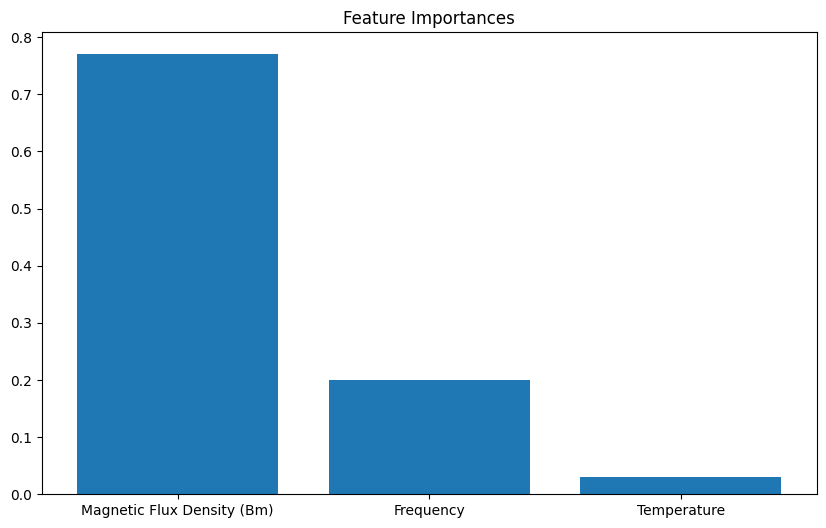

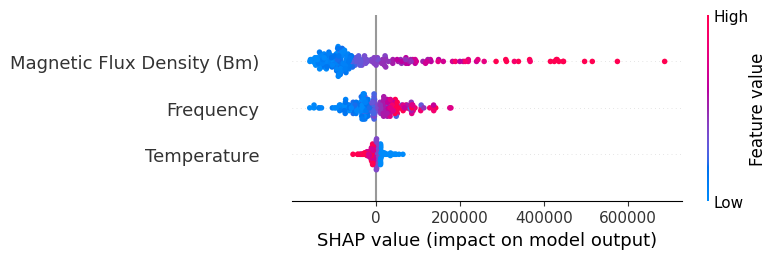

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# 数据读取与处理
data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx')
data.columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(1024)]
data = data[data['waveform'] == '正弦波']  # 只选择正弦波

# 特征提取 (频率, 磁通密度的峰值, 温度)
f = data['f/Hz'].values
Bm = np.max(data.iloc[:, 4:].values, axis=1)
T = data['T/oC'].values
P_real = data['P_w/m3'].values

# 组合特征 (频率, 磁通密度, 温度)
X = np.column_stack((f, Bm, T))
y = P_real

# 训练集和测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 随机森林回归
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 模型预测
y_pred = rf.predict(X_test)

# 评价指标
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Error:", (np.abs(y_test - y_pred) / y_test * 100).mean())

# 可视化特征重要性
importances = rf.feature_importances_
feature_names = ['Frequency', 'Magnetic Flux Density (Bm)', 'Temperature']
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.show()

# 使用SHAP解释模型
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# 可视化SHAP值
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 超参数网格
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 创建随机森林回归模型
rf = RandomForestRegressor(random_state=42)

# 网格搜索
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print(f"最佳参数组合: {grid_search.best_params_}")

# 使用最佳参数训练随机森林模型
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# 评估结果
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"优化后的MSE: {mse}")
print(f"优化后的R2 Score: {r2}")
print("Error:", (np.abs(y_test - y_pred) / y_test * 100).mean())


Fitting 3 folds for each of 216 candidates, totalling 648 fits
最佳参数组合: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
优化后的MSE: 1449507726.339818
优化后的R2 Score: 0.951782135064591
Error: 17.99015617760059


In [ ]:
# 输出特征重要性
importances = best_rf.feature_importances_
feature_names = ['Frequency', 'Magnetic Flux Density (Bm)', 'Temperature']
sorted_indices = np.argsort(importances)[::-1]

# 打印每个特征的重要性
for idx in sorted_indices:
    print(f"Feature: {feature_names[idx]}, Importance: {importances[idx]}")

# 如果某些特征重要性特别低，可以考虑去除


Feature: Magnetic Flux Density (Bm), Importance: 0.7698148837718789
Feature: Frequency, Importance: 0.2016740011868538
Feature: Temperature, Importance: 0.028511115041267195


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# XGBoost 参数范围
param_distributions = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# 创建 XGBoost 回归模型
xgb = XGBRegressor(random_state=42)

# 随机搜索
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# 输出最佳参数
print(f"XGBoost 最佳参数: {random_search.best_params_}")

# 使用最佳参数训练XGBoost模型
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# 评估XGBoost结果
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost 优化后的MSE: {mse_xgb}")
print(f"XGBoost 优化后的R2 Score: {r2_xgb}")
print("Error:", (np.abs(y_test - y_pred) / y_test * 100).mean())


Fitting 3 folds for each of 100 candidates, totalling 300 fits
XGBoost 最佳参数: {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGBoost 优化后的MSE: 579736604.5283469
XGBoost 优化后的R2 Score: 0.980715065682439
Error: 17.99015617760059


2. 生成可解释公式的改进方法：符号回归

使用 符号回归 来生成一个 数学公式 解释温度、频率、磁通密度与磁芯损耗之间的关系。符号回归是一种通过进化算法寻找公式的技术，它能够自动生成一个符合数据关系的数学表达式。

In [ ]:
!pip install pysr  # 安装 PySR

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor

# 数据读取与处理
data = pd.read_excel('/content/drive/MyDrive/loss modelling of magnetic components/train_data.xlsx')
data.columns = ['T/oC', 'f/Hz', 'P_w/m3', 'waveform'] + [f'B(t)_{i}' for i in range(1024)]
data = data[data['waveform'] == '正弦波']  # 只选择正弦波

# 特征提取 (频率, 磁通密度的峰值, 温度)
f = data['f/Hz'].values
Bm = np.max(data.iloc[:, 4:].values, axis=1)
T = data['T/oC'].values
P_real = data['P_w/m3'].values

# 组合特征 (频率, 磁通密度, 温度)
X = np.column_stack((f, Bm, T))
y = P_real

# 使用符号回归寻找公式
model = PySRRegressor(
    niterations=1000,  # 迭代次数
    unary_operators=["exp", "log", "sin", "cos"],  # 一元运算符
    binary_operators=["+", "-", "*", "/", "^"],  # 二元运算符
)

model.fit(X, y)

# 打印符号回归找到的最优公式
print(model.get_best())

# 预测
y_pred = model.predict(X)

# 评估
print("MSE:", mean_squared_error(y, y_pred))
print("R2 Score:", r2_score(y, y_pred))


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:73: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnings.warn(


Compiling Julia backend...


[ Info: Started!


流式输出内容被截断，只能显示最后 5000 行内容。
3           1.207e+10  4.496e-01  y = 1.622e+06 * x₁
5           5.417e+09  4.007e-01  y = x₀ ^ (0.90491 + x₁)
6           4.327e+09  2.246e-01  y = (x₀ ^ exp(x₁)) * 0.25751
7           1.646e+09  9.665e-01  y = x₁ * ((x₀ * x₁) ^ 1.4631)
9           1.622e+09  7.292e-03  y = (((x₁ * x₀) - x₂) ^ 1.4636) * x₁
11          6.098e+08  4.892e-01  y = (((x₁ * x₀) ^ 1.4235) * x₁) / cos(cos(x₂))
12          1.904e+08  1.164e+00  y = (x₁ * ((x₀ * x₁) ^ 1.4354)) / cos(cos(log(x₂)))
13          1.426e+08  2.895e-01  y = (x₁ * ((x₁ * x₀) ^ 1.4263)) / sin(cos(cos(log(x₂))))
14          1.376e+08  3.579e-02  y = (x₁ * ((x₁ * x₀) ^ 1.4402)) / cos(cos(log(x₂)) / 1.0666)
15          1.363e+08  9.049e-03  y = ((((x₀ * x₁) ^ 1.4264) * x₁) / sin(cos(cos(log(x₂))))) + -...
                                  2482
17          1.282e+08  3.086e-02  y = ((((x₀ * x₁) ^ 1.4264) * x₁) / sin(cos(cos(log(x₂))))) - (...
                                  x₂ ^ 1.8861)
19          1.268e+08  5.

In [ ]:
(np.abs(y - y_pred) / y * 100).mean()

25.465868395710842

**问题五 磁性元件的最优化条件**

在磁性元件的设计与优化领域内，磁芯损耗固然是一个不容忽视的核心评价指标，但在工程实践中，为了实现磁性元件整体性能的卓越与最优化，需要综合考虑多个评价指标，其中，传输磁能就是重要的评价指标之一，因此，同时考虑磁芯损耗与传输磁能这二个评价指标，对于指导磁性元件的设计方向、优化其性能表现，具有重要的理论及实践意义。

请以问题四构建的磁芯损耗预测模型为目标函数，同时考虑传输磁能这个重要指标（由于传输磁能概念的复杂性，我们仅以频率与磁通密度峰值的乘积来衡量传输磁能大小），利用附件一中的实验数据，建立优化模型，分析在什么条件下（温度、频率、波形、磁通密度峰值及磁芯材料），能达到最小的磁芯损耗以及具有最大的传输磁能（即 f * Bm 达到最大）？

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pyswarm import pso

# 斯坦麦茨方程模型
def steinmetz(f_Bm, k1, alpha1, beta1):
    f, Bm = f_Bm
    return k1 * (f ** alpha1) * (Bm ** beta1)

def steinmetz_with_temp(f_Bm_T, k1, alpha1, beta1, c, T0=25):
    f, Bm, T = f_Bm_T
    return k1 * (f ** alpha1) * (Bm ** beta1) * (c * (T / T0))

def steinmetz_with_nonlinear_temp(f_Bm_T, k1, alpha1, beta1, c1, c2, T0=25):
    f, Bm, T = f_Bm_T
    # return k1 * (f ** alpha1) * (Bm ** beta1) * (c1 * (T / T0) ** c2)
    return k1 * (f ** alpha1) * (Bm ** beta1) * (c1 * (T / T0) ** c2 )

# 自定义 PSO 类
class EnhancedPSO:
    def __init__(self, func, lb, ub, args, swarmsize=50, maxiter=100,
                 inertia_weight=0.9, inertia_damp=0.99, c1=2.0, c2=2.0, seed=None):
        self.func = func
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.args = args
        self.swarmsize = swarmsize
        self.maxiter = maxiter
        self.inertia_weight = inertia_weight
        self.inertia_damp = inertia_damp
        self.c1 = c1
        self.c2 = c2
        self.history = []  # 记录每次迭代的全局最佳值
        self.best_positions = []  # 记录每次迭代的全局最佳位置

    def optimize(self):
        # np.random.seed(self.seed)
        dim = len(self.lb)
        swarm = np.random.uniform(self.lb, self.ub, (self.swarmsize, dim))
        velocity = np.zeros((self.swarmsize, dim))
        personal_best = np.copy(swarm)
        personal_best_value = np.array([self.func(p, *self.args) for p in swarm])
        global_best = personal_best[np.argmin(personal_best_value)]
        global_best_value = np.min(personal_best_value)

        for i in range(self.maxiter):
            for j in range(self.swarmsize):
                # 更新速度
                r1, r2 = np.random.rand(dim), np.random.rand(dim)
                velocity[j] = (self.inertia_weight * velocity[j] +
                               self.c1 * r1 * (personal_best[j] - swarm[j]) +
                               self.c2 * r2 * (global_best - swarm[j]))

                # 更新位置
                swarm[j] += velocity[j]
                swarm[j] = np.clip(swarm[j], self.lb, self.ub)

                # 计算新的目标函数值
                current_value = self.func(swarm[j], *self.args)

                # 更新个体最佳位置
                if current_value < personal_best_value[j]:
                    personal_best[j] = swarm[j]
                    personal_best_value[j] = current_value

                # 更新全局最佳位置
                if current_value < global_best_value:
                    global_best = swarm[j]
                    global_best_value = current_value

            # 动态调整惯性权重
            self.inertia_weight *= self.inertia_damp

            # 记录每次迭代的全局最佳值和位置
            self.history.append(global_best_value)
            self.best_positions.append(global_best)

            if i % 500 == 0:
              print(f"Iteration {i+1}/{self.maxiter}, Global Best Value: {global_best_value:.6f}")

        return global_best, global_best_value

# 目标函数，计算误差（使用向量化）
def objective_func(params, func, f, Bm, T, P_real):
    if T is not None:
        f_Bm_T = np.vstack((f, Bm, T)).T
    else:
        f_Bm_T = np.vstack((f, Bm)).T

    # 批量计算预测值
    P_pred = func(f_Bm_T.T, *params)

    # 计算误差并返回平均值
    return np.mean(np.abs(P_real - P_pred) / P_real)

# PSO 优化过程
def pso_optimize(func, lb, ub, f, Bm, T, P_real, swarmsize=100, maxiter=1000):
    # 确定是否传递 T
    if len(lb) == 3:
        T = None  # 对于传统斯坦麦茨方程，T 为 None
    pso_optimizer = EnhancedPSO(objective_func, lb, ub, args=(func, f, Bm, T, P_real), swarmsize=swarmsize, maxiter=maxiter)
    best_solution, best_value = pso_optimizer.optimize()
    return best_solution, pso_optimizer.history  # 返回最优解和优化历史

# 拟合三种斯坦麦茨方程
def fit_steinmetz_models(f, Bm, T, material, waveform, P_real, transmission_energy):
    bounds = (-10, 10)
    models = {
        'steinmetz': (steinmetz, [bounds[0]] * 3, [bounds[1]] * 3),
        'steinmetz_with_temp': (steinmetz_with_temp, [bounds[0]] * 4, [bounds[1]] * 4),
        'steinmetz_with_nonlinear_temp': (steinmetz_with_nonlinear_temp, [bounds[0]] * 5, [bounds[1]] * 5)
    }

    popt = {}
    history_dict = {}
    function = {}
    for model_name, (model_func, lb, ub) in models.items():
        initial_guess, history = pso_optimize(model_func, lb, ub, f, Bm, T, P_real)
        popt[model_name] = initial_guess
        history_dict[model_name] = history
        function[model_name] = model_func

    return popt, history_dict, function

# 可视化 PSO 优化历史
def plot_optimization_history(f, Bm, T, P_real, popt, history_dict, function):
    plt.figure(figsize=(10, 6))
    for model_name, history in history_dict.items():
        print(f"{model_name} 的最优平均误差: {min(history):.4f}")
        iterations = list(range(1, len(history) + 1))
        plt.plot(iterations, history, label=f'{model_name} history')

    plt.xlabel('Iteration')
    plt.ylabel('Global Best Value')
    plt.title('PSO Optimization History')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    for model_name, position in popt.items():
        print(f"{model_name} 的最优拟合参数: {position}")
        func = function[model_name]
        # 确定是否传递 T
        if model_name == 'steinmetz':
            f_Bm_T = np.vstack((f, Bm)).T
        else:
            f_Bm_T = np.vstack((f, Bm, T)).T

        # 批量计算预测值
        P_pred = func(f_Bm_T.T, *position)

        # 计算误差并返回平均值
        errors = np.abs(P_real - P_pred) / P_real

        plt.plot(T, errors, label=f"Error of the {model_name} equation")

    plt.xlabel('Temperature (°C)')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.title('Prediction Errors for Different Models')
    plt.grid()
    plt.show()

    # 绘制拟合结果与真实数据
    plt.figure(figsize=(10, 5))
    for model_name, position in popt.items():
        func = function[model_name]
        if model_name == 'steinmetz':
            f_Bm_T = np.vstack((f, Bm)).T
        else:
            f_Bm_T = np.vstack((f, Bm, T)).T
        P_pred = func(f_Bm_T.T, *position)
        errors = np.abs(P_real - P_pred) / P_real

        plt.plot(errors, label=f"Error of the {model_name} equation")

    # plt.plot(P_real, label="Real Core Loss")
    plt.xlabel('Operating conditions')
    plt.ylabel('Error Scaled Density')
    plt.legend()
    plt.title('Height Distribution of Core Loss Density Prediction Error')
    plt.grid()
    plt.show()

# 主程序调用示例
if __name__ == "__main__":
    # 数据加载
    data = pd.read_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_train_data.csv')
    # 创建标签列表
    labels = ['material_1'] * 3400 + ['material_2'] * 3000 + ['material_3'] * 3200 + ['material_4'] * 2800

    # 确保标签数量与 DataFrame 行数一致
    if len(labels) == len(data):
      data['material'] = labels
    else:
      print(f"标签数量 ({len(labels)}) 与 DataFrame 行数 ({len(data)}) 不一致")

    # 计算传输磁能
    data['Bm'] = np.max(data.iloc[:, 4:1028].values, axis=1)
    data['transmission_energy'] = data['f/Hz'] * data['Bm']

    f = data['f/Hz'].values
    Bm = data['Bm'].values
    T = data['T/oC'].values
    material = data['material'].values
    waveform = data['waveform'].values

    P_real = data['P_w/m3'].values # 磁芯损耗
    transmission_energy = f * Bm  # 传输磁能

    # 拟合模型
    popt, history_dict, function = fit_steinmetz_models(f, Bm, T, material, waveform, P_real, transmission_energy)

    # 查看优化历史
    plot_optimization_history(f, Bm, T, P_real, popt, history_dict, function)


In [ ]:
import pandas as pd
import numpy as np
# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_train_data.csv')

# 创建标签列表
labels = ['material_1'] * 3400 + ['material_2'] * 3000 + ['material_3'] * 3200 + ['material_4'] * 2800

# 确保标签数量与 DataFrame 行数一致
if len(labels) == len(data):
   data['material'] = labels
else:
   print(f"标签数量 ({len(labels)}) 与 DataFrame 行数 ({len(data)}) 不一致")

# 计算传输磁能
data['Bm'] = np.max(data.iloc[:, 4:1028].values, axis=1)
data['transmission_energy'] = data['f/Hz'] * data['Bm']

# Define features and target
X = data[['f/Hz', 'Bm', 'T/oC', 'material', 'waveform']]
X = pd.get_dummies(X)  # One-hot encoding for 'material' and 'waveform'
y = data['P_w/m3']


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_train_data.csv')

# 创建标签列表
labels = ['material_1'] * 3400 + ['material_2'] * 3000 + ['material_3'] * 3200 + ['material_4'] * 2800

# 确保标签数量与 DataFrame 行数一致
if len(labels) == len(data):
   data['material'] = labels
else:
   print(f"标签数量 ({len(labels)}) 与 DataFrame 行数 ({len(data)}) 不一致")

# 计算传输磁能
data['Bm'] = np.max(data.iloc[:, 4:1028].values, axis=1)
data['transmission_energy'] = data['f/Hz'] * data['Bm']

# Define features and target
X = data[['f/Hz', 'Bm', 'T/oC', 'material', 'waveform']]
X = pd.get_dummies(X)  # One-hot encoding for 'material' and 'waveform'
y = data['P_w/m3']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'MLP Regressor': MLPRegressor(max_iter=500),
    'XGBoost': XGBRegressor(),
    'Polynomial Regression (degree 2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'LGBM': LGBMRegressor()
}

# Train models and make predictions
model_predictions = {}
model_errors = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred
    model_errors[name] = (np.abs(y_test - y_pred) / y_test).mean()

print(model_errors)
# Calculate model weights (higher RMSE means lower weight)
total_error = sum(1 / np.array(list(model_errors.values())))
weights = {name: (1 / error) / total_error for name, error in model_errors.items()}

# Weighted average of predictions
final_prediction = np.zeros(len(y_test))
for name, weight in weights.items():
    final_prediction += weight * model_predictions[name]

# Calculate final RMSE of the ensemble
final_error = (np.abs(y_test - final_prediction) / y_test).mean()

print(f"Final Error of the weighted ensemble: {final_error}")
print(f"Model weights: {weights}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 9920, number of used features: 8
[LightGBM] [Info] Start training from score 200720.099339
{'Linear Regression': 14.151583874272074, 'Decision Tree': 0.1710709252929768, 'Random Forest': 0.13405496283147864, 'Gradient Boosting': 1.3855008638326942, 'SVR': 4.278012683163094, 'KNeighbors Regressor': 3.0795680520784403, 'MLP Regressor': 11.4860811949614, 'XGBoost': 0.2212076360540134, 'Polynomial Regression (degree 2)': 4.154034260747908, 'LGBM': 0.34566591986748907}
Final Error of the weighted ensemble: 0.19176762595761687
Model weights: {'Linear Regression': 0.0031549780101335946, 'Decision Tree': 0.26099078996284925, 'Random Forest': 0.3330569416368179, 'Gradient Boosting': 

In [ ]:
final_prediction.min()

621.872803147708

In [ ]:
import pickle

# Save the models
for name, model in models.items():
    with open(f'{name}_model.pkl', 'wb') as file:
        pickle.dump(model, file)

In [ ]:
import numpy as np

# Assuming models have already been trained and are stored as:
# decision_tree_model, random_forest_model, xgboost_model, lgbm_model
# To load the models later
loaded_models = {}
for name in models.keys():
    with open(f'{name}_model.pkl', 'rb') as file:
        loaded_models[name] = pickle.load(file)

# Define the model weights as per your best ensemble
model_weights = {
    'Decision Tree': 0.18374953260347832,
    'Random Forest': 0.2753745336925355,
    'XGBoost': 0.3016954692131632,
    'LGBM': 0.23918046449082295
}

def predict_core_loss(f, Bm, T, material, waveform):
    # Create a feature vector (ensure this matches the format your models expect)
    # Note: This assumes you are not doing one-hot encoding on 'material' and 'waveform'
    feature_vector = np.array([[f, Bm, T, material, waveform]])

    # Get predictions from each model
    decision_tree_pred = decision_tree_model.predict(feature_vector)
    random_forest_pred = random_forest_model.predict(feature_vector)
    xgboost_pred = xgboost_model.predict(feature_vector)
    lgbm_pred = lgbm_model.predict(feature_vector)

    # Calculate weighted prediction
    P_pred = (model_weights['Decision Tree'] * decision_tree_pred +
              model_weights['Random Forest'] * random_forest_pred +
              model_weights['XGBoost'] * xgboost_pred +
              model_weights['LGBM'] * lgbm_pred)

    return P_pred[0]  # Return the single predicted value


In [ ]:
import numpy as np
import pandas as pd
import pickle
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/loss modelling of magnetic components/processed_train_data.csv')
labels = ['material_1'] * 3400 + ['material_2'] * 3000 + ['material_3'] * 3200 + ['material_4'] * 2800
data['material'] = labels
data['Bm'] = np.max(data.iloc[:, 4:1028].values, axis=1)
data['transmission_energy'] = data['f/Hz'] * data['Bm']

# Define features and target
X = data[['f/Hz', 'Bm', 'T/oC', 'material', 'waveform']]
X = pd.get_dummies(X)  # One-hot encoding for 'material' and 'waveform'
y = data['P_w/m3']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'LGBM': LGBMRegressor()
}

# Train models and collect predictions
model_predictions = {}
model_errors = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred
    model_errors[name] = (np.abs(y_test - y_pred) / y_test).mean()

# Calculate weights for ensemble
total_error = sum(1 / np.array(list(model_errors.values())))
weights = {name: (1 / error) / total_error for name, error in model_errors.items()}

# Weighted average of predictions
final_prediction = sum(weights[name] * model_predictions[name] for name in weights)
final_error = (np.abs(y_test - final_prediction) / y_test).mean()

# Save the models
for name, model in models.items():
    with open(f'{name}_model.pkl', 'wb') as file:
        pickle.dump(model, file)

# Define the objective function for optimization
def objective_function(params):
    f, Bm, T_index, material_index, waveform_index = params
    T_values = [25, 50, 70, 90]
    material_values = ['material_1', 'material_2', 'material_3', 'material_4']
    waveform_values = [1, 2, 3]

    T = T_values[int(T_index)]
    material = material_values[int(material_index)]
    waveform = waveform_values[int(waveform_index)]

    # Prepare input for prediction
    X_input = pd.DataFrame([[f, Bm, T, material, waveform]],
                            columns=['f/Hz', 'Bm', 'T/oC', 'material', 'waveform'])
    X_input = pd.get_dummies(X_input, columns=['material', 'waveform'], drop_first=True)
    X_input = X_input.reindex(columns=X_train.columns, fill_value=0)  # Ensure matching columns

    # Calculate final prediction
    final_prediction = sum(weights[name] * model.predict(X_input)[0] for name in weights)
    transmission_energy = f * Bm
    return abs(final_prediction - transmission_energy)

# Define bounds for the optimization
bounds = [
    (32000, 50000),        # f (frequency)
    (0.012, 0.26),         # Bm (flux density)
    (0, 3),                # T (temperature index for [25, 50, 70, 90])
    (0, 3),                # material index for ['material_1', 'material_2', 'material_3', 'material_4']
    (0, 2)                 # waveform
]

# Run the optimization
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=1000, tol=1e-6)
optimized_params = result.x

# Decode optimized categorical values
optimized_T = [25, 50, 70, 90][int(optimized_params[2])]
optimized_material = ['material_1', 'material_2', 'material_3', 'material_4'][int(optimized_params[3])]
optimized_f = optimized_params[0]
optimized_Bm = optimized_params[1]
optimized_waveform = [1, 2, 3][int(optimized_params[4])]

print(f'Optimized f: {optimized_f}, Optimized Bm: {optimized_Bm}, Optimized T: {optimized_T}, Optimized Material: {optimized_material}, Optimized Waveform: {optimized_waveform}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 9920, number of used features: 8
[LightGBM] [Info] Start training from score 200720.099339
Optimized f: 40079.60255335429, Optimized Bm: 0.013145195786475425, Optimized T: 25, Optimized Material: material_1, Optimized Waveform: 3


In [ ]:
# Visualization
for name, preds in model_predictions.items():
    plt.scatter(y_test, preds, label=name, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Core Loss')
plt.ylabel('Predicted Core Loss')
plt.title('Predicted vs Actual Core Loss')
plt.legend()
plt.show()

# Calculate RMSE for visualization
for name, preds in model_predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f'RMSE for {name}: {rmse}')

{'Decision Tree': 0.2812085133286829,
 'Random Forest': 0.3574944723163138,
 'XGBoost': 0.22031026762111555,
 'LGBM': 0.14098674673388775}

In [ ]:
Bm.min()

0.012286724

**1.差分进化（DE）**
- 类型：无梯度、全局优化算法

- 最适合：非凸和非线性问题

- 工作原理：它根据差分运算将现有的解决方案组合起来，进化出一个候选解决方案群体，并通过突变和交叉运算确保多样性

- 优点：有效解决复杂、嘈杂和多模式景观问题。

- Libraries: scipy.optimize.differential_evolution.

In [ ]:
from scipy.optimize import differential_evolution

def objective_function(x):
    f, Bm, T, material, waveform = x
    transmission_energy = f * Bm
    P_real = predict_core_loss(f, Bm, T, material, waveform)  # Your prediction model
    return np.abs(P_real - transmission_energy)

bounds = [(min_f, max_f), (min_Bm, max_Bm), (min_T, max_T), (min_material, max_material), (min_waveform, max_waveform)]
result = differential_evolution(objective_function, bounds)
print(result.x, result.fun)


**2.遗传算法（GA）**

- 类型：基于种群的进化算法

- 最适合：非线性问题和组合问题

- 工作原理：模拟自然选择过程，通过变异、交叉和选择产生连续几代候选解决方案

- 优点：能够避免局部最小值并处理较大的搜索空间。

- Libraries: DEAP, PyGAD.

In [ ]:
from pygad import GA

def fitness_func(solution, solution_idx):
    f, Bm, T, material, waveform = solution
    transmission_energy = f * Bm
    P_real = predict_core_loss(f, Bm, T, material, waveform)  # Your model
    return -np.abs(P_real - transmission_energy)  # Maximize negative error (i.e., minimize error)

ga_instance = GA(num_generations=100, num_parents_mating=5,
                 fitness_func=fitness_func, sol_per_pop=10, num_genes=5,
                 gene_space=[(min_f, max_f), (min_Bm, max_Bm), (min_T, max_T), (min_material, max_material), (min_waveform, max_waveform)])

ga_instance.run()
best_solution, best_solution_fitness = ga_instance.best_solution()
print(best_solution, best_solution_fitness)


**3.模拟退火（SA）**

- 类型：随机全局搜索算法

- 最适合：大型、噪声大和离散的搜索空间

- 工作原理：受冶金退火过程的启发，SA 从一个较高的 "温度 "开始探索解空间，随着温度的降低，较差的解被接受的概率也会降低

- 优点：适用于有许多局部最小值的问题。

- Libraries: scipy.optimize.dual_annealing.

In [ ]:
from scipy.optimize import dual_annealing

def objective_function(x):
    f, Bm, T, material, waveform = x
    transmission_energy = f * Bm
    P_real = predict_core_loss(f, Bm, T, material, waveform)  # Your model
    return np.abs(P_real - transmission_energy)

bounds = [(min_f, max_f), (min_Bm, max_Bm), (min_T, max_T), (min_material, max_material), (min_waveform, max_waveform)]
result = dual_annealing(objective_function, bounds)
print(result.x, result.fun)


**4.粒子群优化（PSO）**

- 类型：基于种群的无梯度优化技术

- 类型：基于种群的无梯度优化技术

- 最适合：连续、非线性优化问题

- 工作原理：利用粒子群来探索求解空间。每个粒子根据自身和邻近粒子的经验调整位置

- 优点：对于优化连续函数简单有效，并能高效找到全局最优。

- Libraries: pyswarm, pyswarm.pso.

In [ ]:
from pyswarm import pso

def objective_function(x):
    f, Bm, T, material, waveform = x
    transmission_energy = f * Bm
    P_real = predict_core_loss(f, Bm, T, material, waveform)
    return np.abs(P_real - transmission_energy)

lb = [min_f, min_Bm, min_T, min_material, min_waveform]
ub = [max_f, max_Bm, max_T, max_material, max_waveform]

best_solution, best_error = pso(objective_function, lb, ub)
print(best_solution, best_error)


**5.贝叶斯优化（BO）**

- 类型：类型：基于替代模型的概率优化技术

- 最适合：昂贵的函数评估或黑箱优化问题

- 工作原理：BO 使用代用模型（通常是高斯过程）来近似目标函数，并通过平衡探索和利用来引导寻找最小值

- 优点：当函数评估成本较高或噪声较大时非常有效。

- Libraries: skopt, bayesian-optimization.

In [ ]:
from skopt import gp_minimize

def objective_function(x):
    f, Bm, T, material, waveform = x
    transmission_energy = f * Bm
    P_real = predict_core_loss(f, Bm, T, material, waveform)
    return np.abs(P_real - transmission_energy)

bounds = [(min_f, max_f), (min_Bm, max_Bm), (min_T, max_T), (min_material, max_material), (min_waveform, max_waveform)]
result = gp_minimize(objective_function, bounds, n_calls=50)
print(result.x, result.fun)


算法概述： - 微分进化：适合全局优化和寻找多样化解决方案：灵活适用于非线性和组合优化问题：适用于具有许多局部最小值的大型搜索空间：粒子群优化：实施简单，适用于连续变量：贝叶斯优化：最适用于评估成本高或噪声大的问题。

建议方法： 1.从差分演化或粒子群优化开始，对求解空间进行广泛探索。2. 如果问题涉及昂贵的函数求值，或需要在探索和利用之间寻求平衡，则可尝试贝叶斯优化法。3. 对于调整或后期优化，模拟退火或遗传算法可以完善搜索。